In [96]:
import json
import pandas as pd
import numpy as np
from typing import Any
from pathlib import Path

from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import cm

## Load the data:

In [97]:
# Set the file path:
path = "results/"
file_name = "result_GridSearch_ST_max.jsonl"

In [98]:
def parse_results(path: str) -> pd.DataFrame:
    records = []
    with open(path, 'r') as f:
        buffer = []
        depth = 0

        for raw in f:
            line = raw.strip()
            if not line:
                continue  # skip blank lines

            # Track nesting of braces
            depth += line.count('{')
            depth -= line.count('}')

            buffer.append(raw)
            # If we’ve closed all opened braces, process one full JSON object
            if depth == 0 and buffer:
                chunk = ''.join(buffer)
                obj = json.loads(chunk)
                # same flattening logic as before
                for uid, details in obj.items():
                    params = details.pop('params')
                    flat = {'id': uid, **details}
                    for p, v in params.items():
                        if isinstance(v, list) and len(v) == 2:
                            flat[f'{p}_x'] = v[0]
                            flat[f'{p}_y'] = v[1]
                        else:
                            flat[p] = v
                    records.append(flat)
                buffer = []
    return pd.DataFrame(records)

In [99]:
df = parse_results(path + file_name)

In [100]:
df.head()

id          score  total_ghosts  \
0  f90e06d4-5607-4517-8c59-8111839f9ab9  999999.595169             0   
1  6f989245-9e92-4ae7-9f89-45625b8d68e5  999999.294861             0   
2  fceb8a4c-e115-4141-bb8a-fcd619b6bc76  999999.295922             0   
3  a6db1f90-a202-4dba-9005-e7955f8af5b0  999999.262910             0   
4  16eeb726-5817-49e9-92ec-bc884b113601  999999.249081             0   

   overall_ghost_rate  event_avg_ghost_rate  clone_percentage  total_tracks  \
0                 0.0                   0.0               0.0             0   
1                 0.0                   0.0               0.0             0   
2                 0.0                   0.0               0.0             0   
3                 0.0                   0.0               0.0             0   
4                 0.0                   0.0               0.0             0   

       time  scatter  min_strong_track_length  allowed_missed_modules  
0  1.487921      NaN                      NaN                     NaN  
1  0.737152      0.0                      1.0                     1.0  
2  0.739806      0.0                      1.0                     2.0  
3  0.657274      0.0                      1.0                     3.0  
4  0.622702      0.0                      1.0                     4.0

### Get the configuration file from these results

In [101]:
def get_config(file_path: str):
    stem = Path(file_path).stem            
    config_name = stem.removeprefix("result_")      
    
    config_path = Path("configurations") / f"{config_name}.json"
    
    # 3) Open & load the JSON
    with config_path.open("r", encoding="utf-8") as f:
        config = json.load(f)
    return config



In [102]:
configuration = get_config(file_name)
print(configuration)

{'solverName': 'GridSearch', 'num_events': 100, 'intra_node': True, 'max_runs': 1000000, 'optimizer': {'objective': 'min', 'nested': True, 'weights': [0.4, 0.2, 0.3, -5.0], 'resolution': 42}, 'reconstruction_algo': 'ST'}


# Example scripts for plots & Graphs

## SETUP CUSTOM STYLING FOR THE PLOTS

**plot the score / itterations**

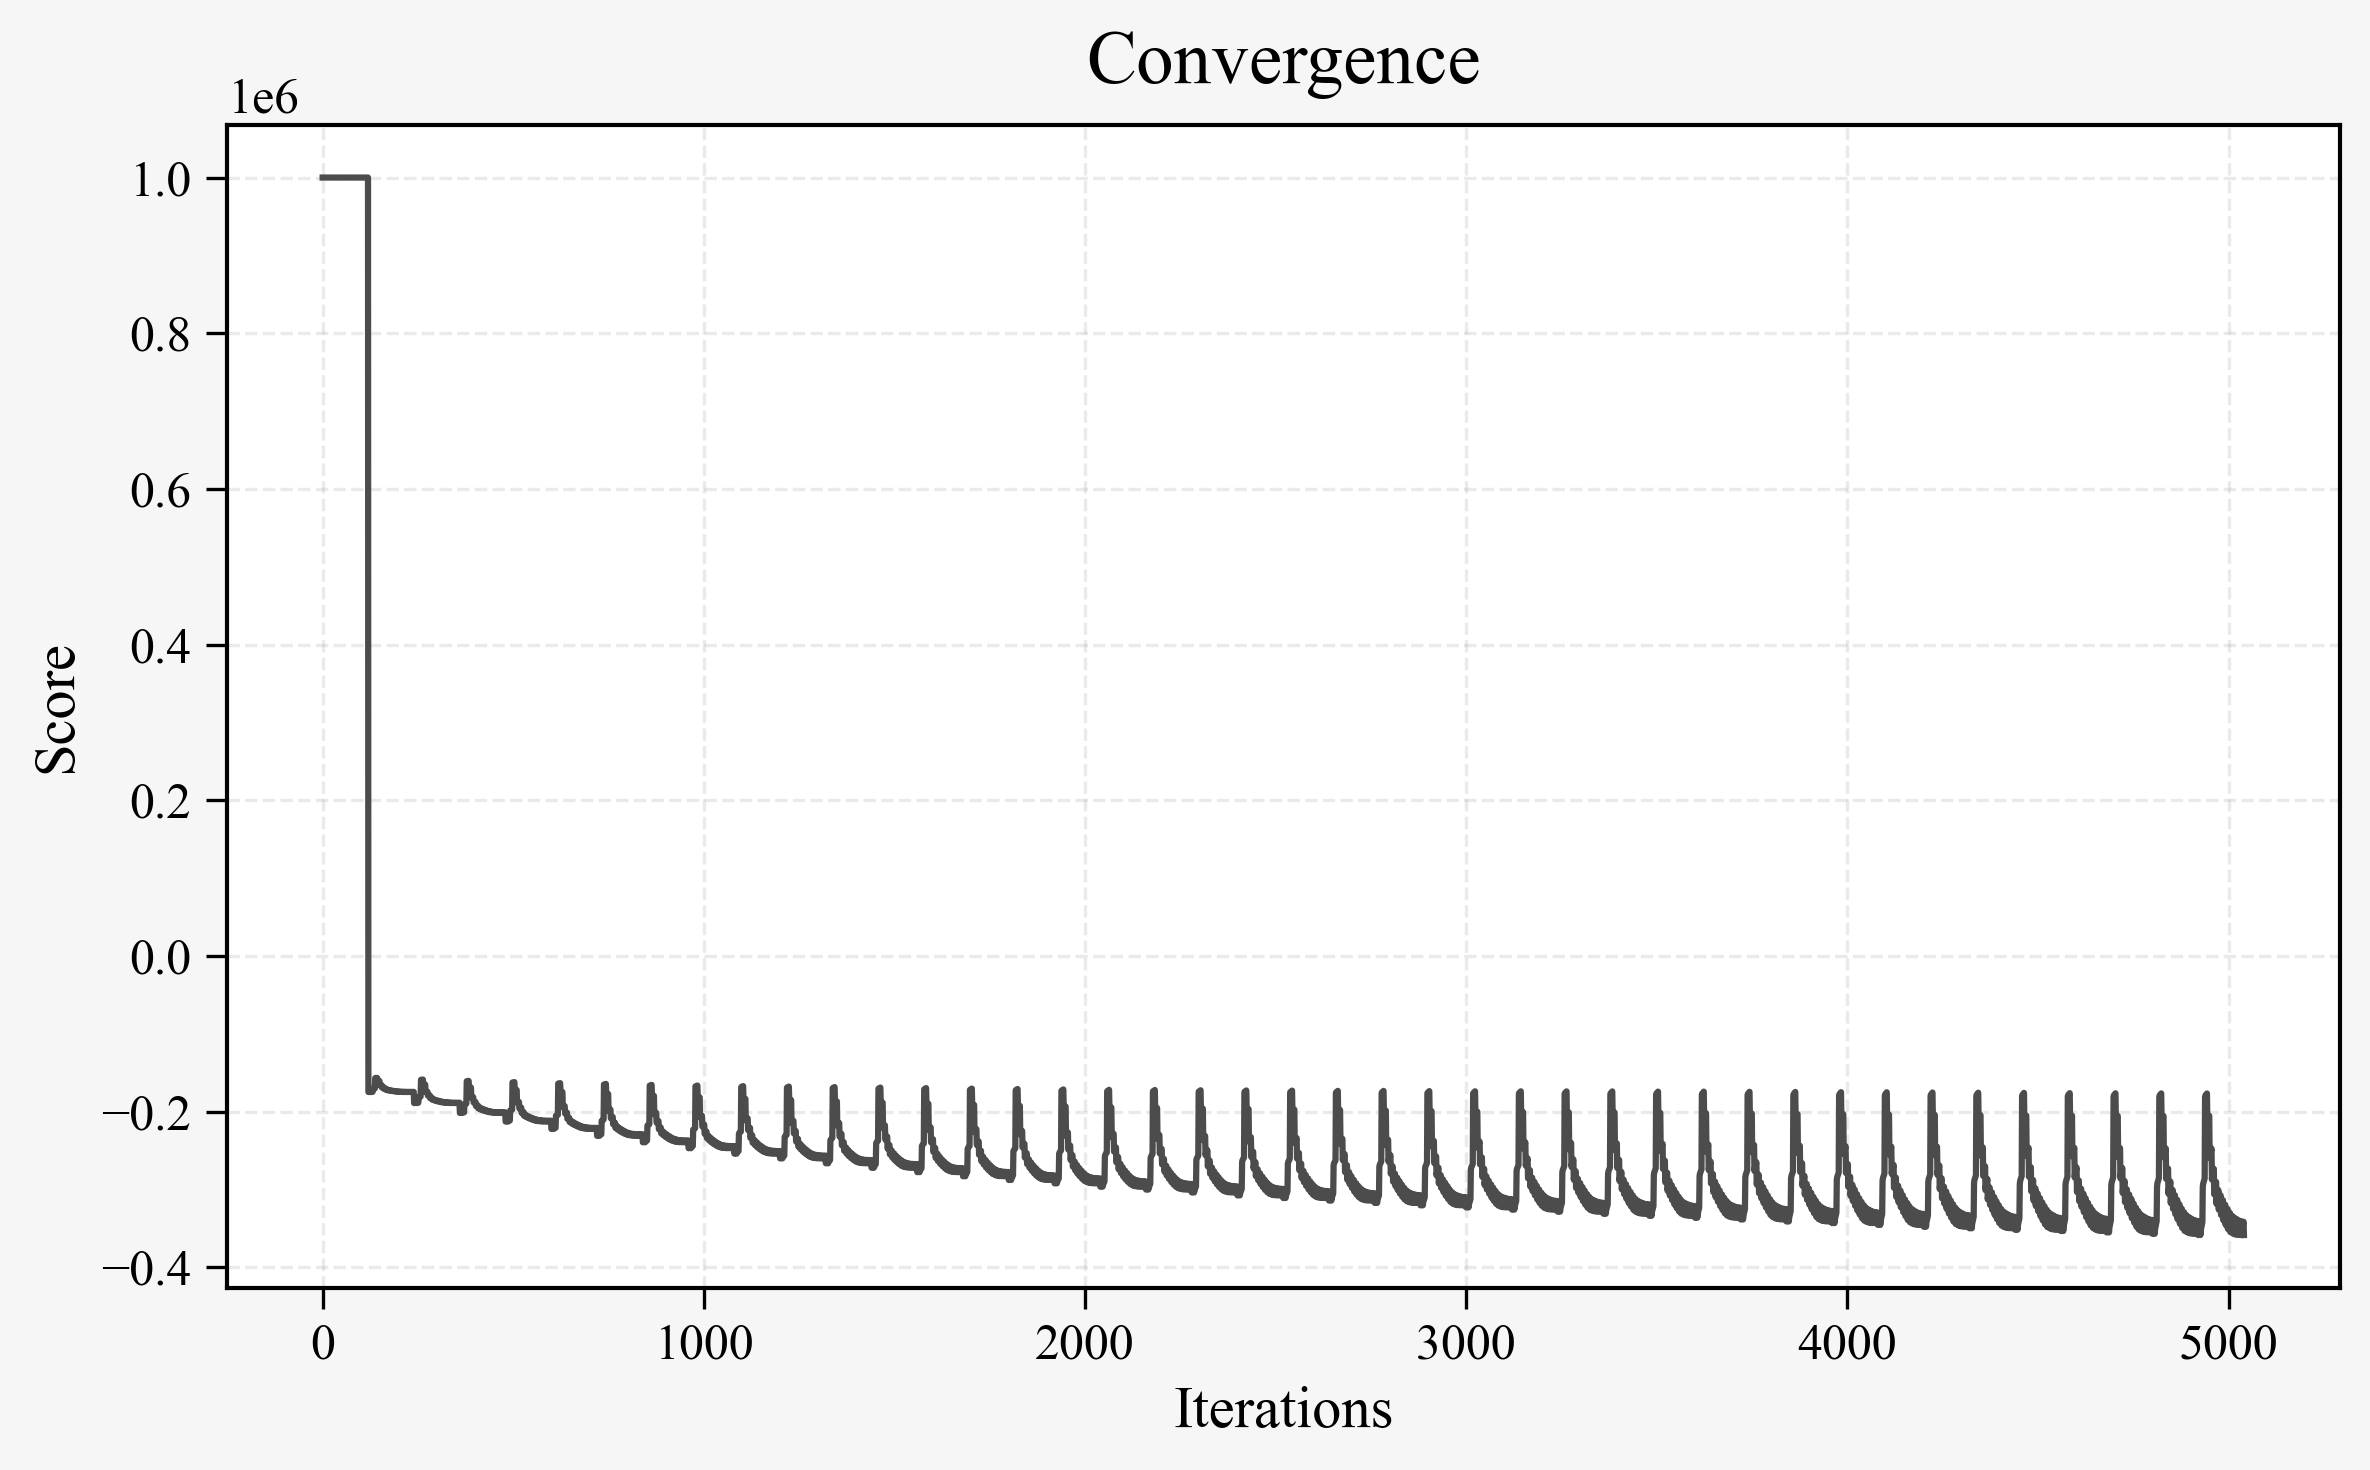

In [103]:
def plot_convergence(
    df,
    figsize=(8, 5),
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    dpi=300,
    color="#4C4C4C",
    linestyle="-",
    linewidth=1.5
):
    # 1) Configure rcParams
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "figure.dpi":        dpi,
        "axes.linewidth":    1.0,
        "xtick.major.size":  5,
        "ytick.major.size":  5,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    # 2) Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(
        df.index,
        df['score'],
        color=color,
        linestyle=linestyle,
        linewidth=linewidth
    )
    ax.set_title("Convergence", pad=10)
    ax.set_xlabel("Iterations", fontsize=label_fontsize)
    ax.set_ylabel("Score", fontsize=label_fontsize)
    ax.grid(True)  # already styled via rcParams

    plt.tight_layout()
    plt.show()

plot_convergence(df)


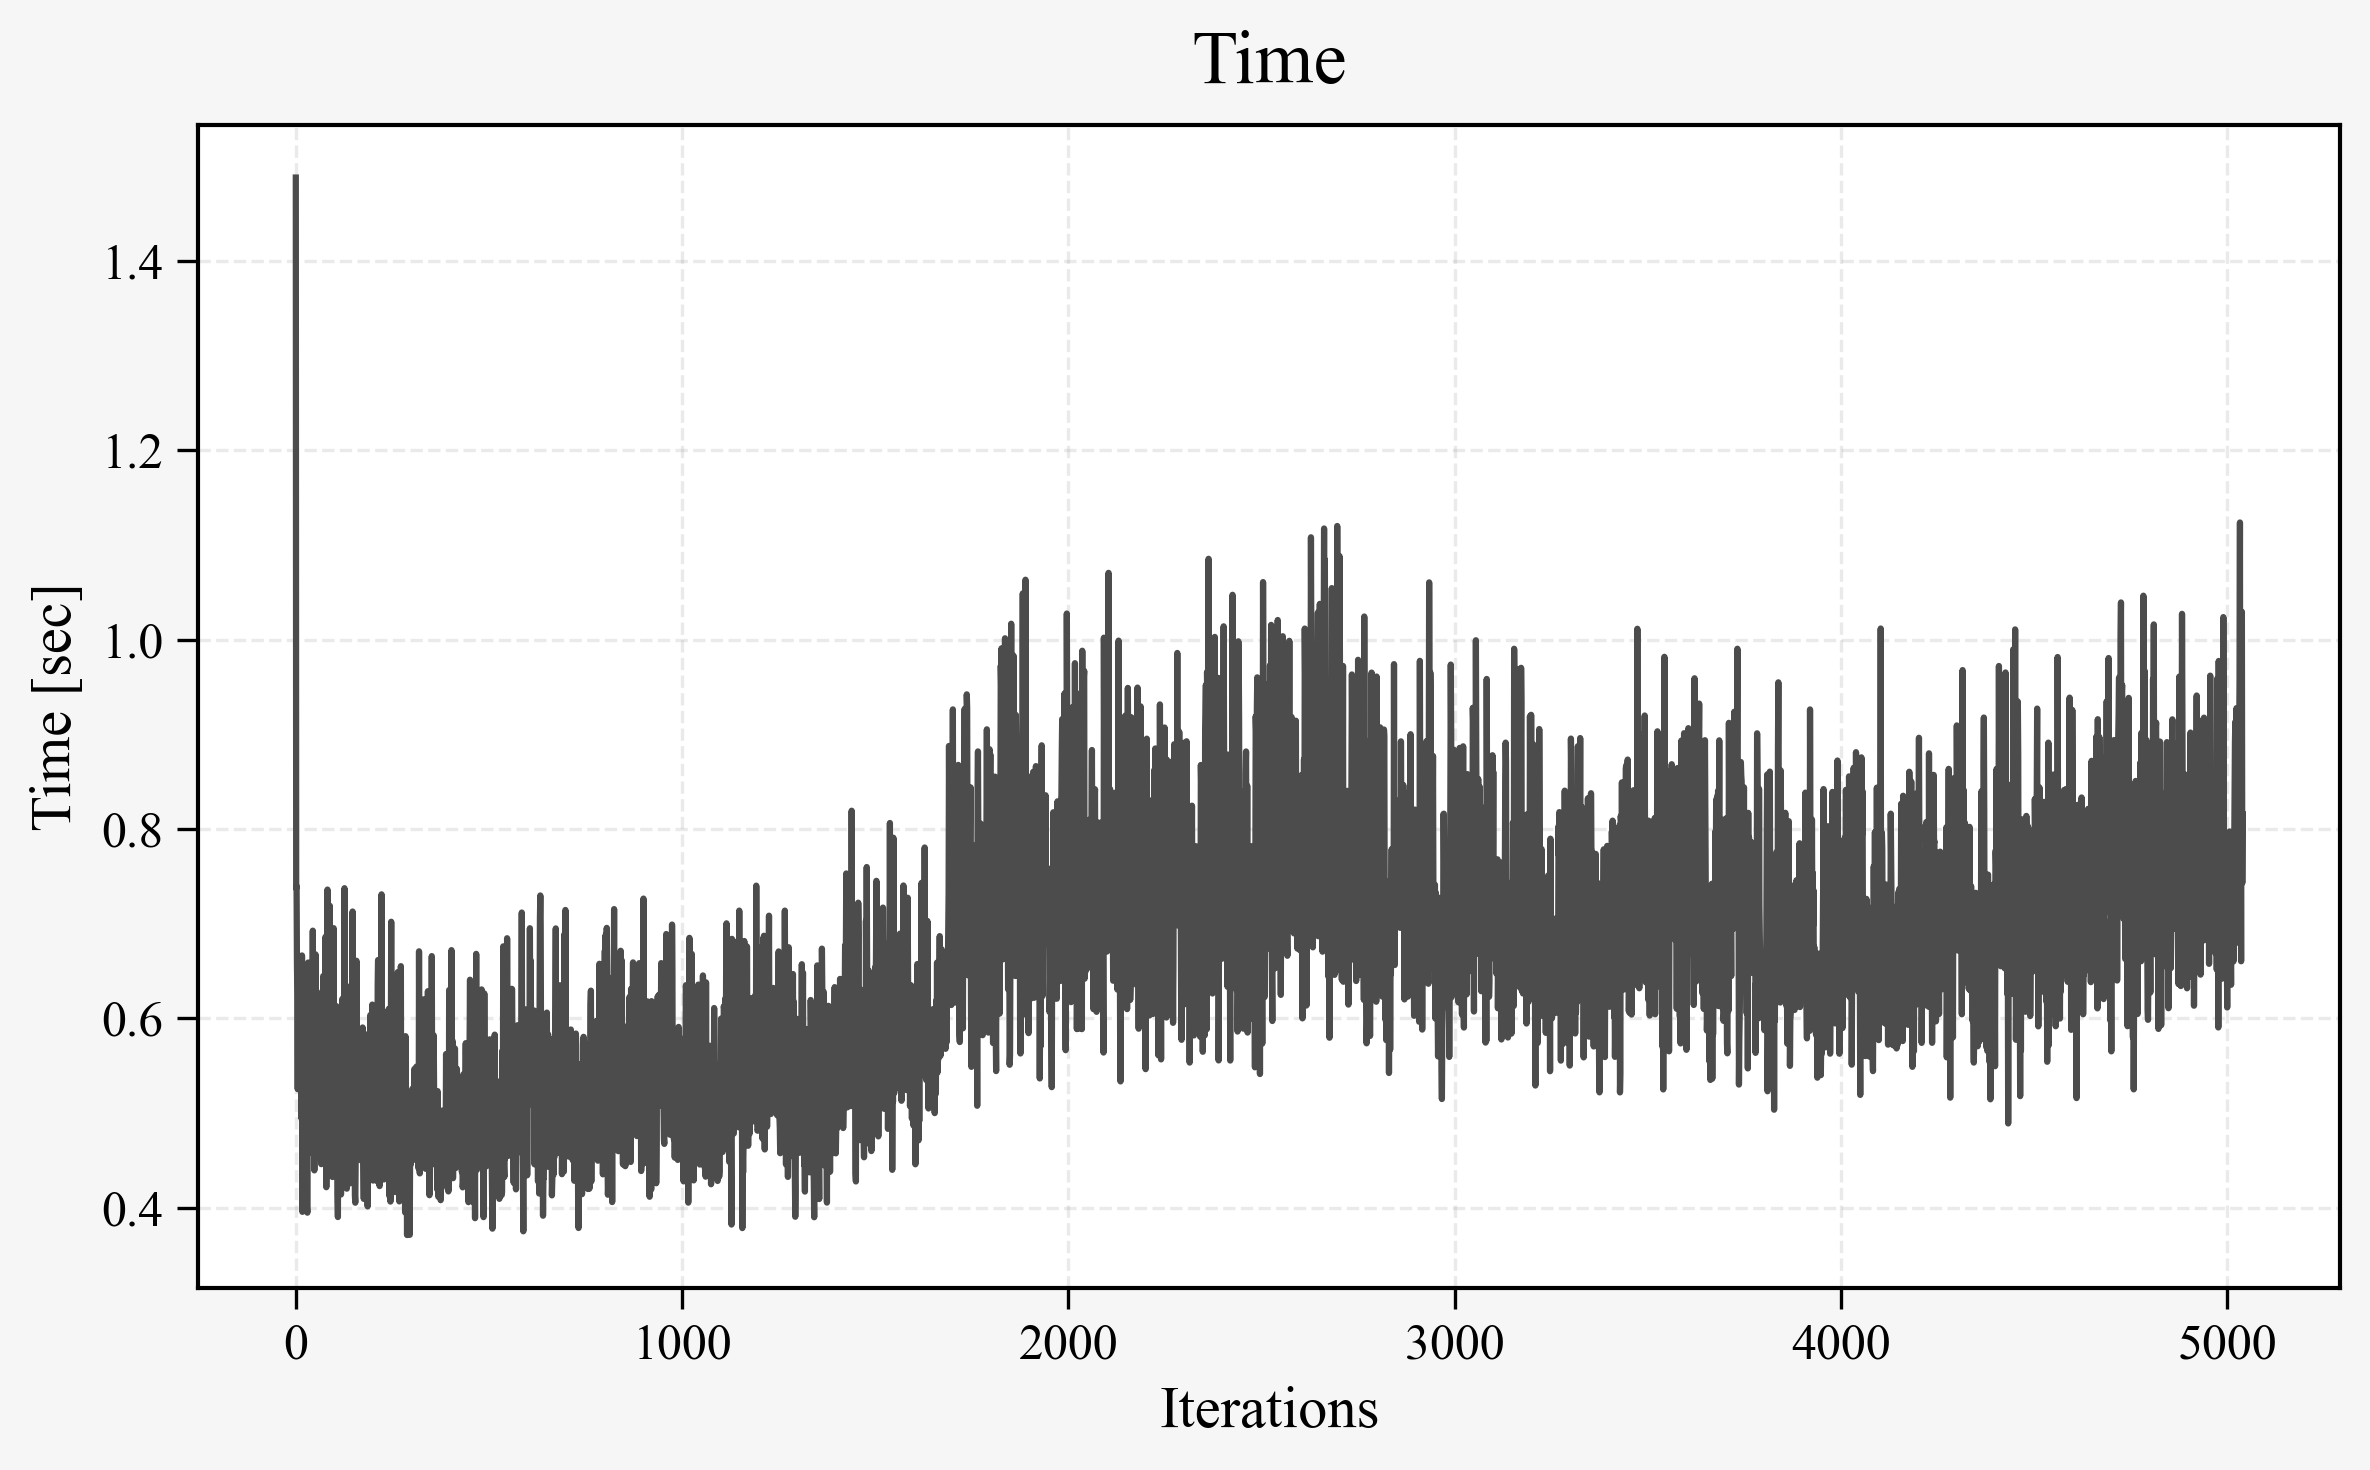

In [104]:
def plot_convergence_time(
    df,
    figsize=(8, 5),
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    dpi=300,
    color="#4C4C4C",
    linestyle="-",
    linewidth=1.5
):
    # 1) Configure rcParams
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "figure.dpi":        dpi,
        "axes.linewidth":    1.0,
        "xtick.major.size":  5,
        "ytick.major.size":  5,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    # 2) Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(
        df.index,
        df['time'],
        color=color,
        linestyle=linestyle,
        linewidth=linewidth
    )
    ax.set_title("Time", pad=10)
    ax.set_xlabel("Iterations", fontsize=label_fontsize)
    ax.set_ylabel("Time [sec]", fontsize=label_fontsize)
    ax.grid(True)  # already styled via rcParams

    plt.tight_layout()
    plt.show()
plot_convergence_time(df)

In [105]:
print(df.columns)

Index(['id', 'score', 'total_ghosts', 'overall_ghost_rate',
       'event_avg_ghost_rate', 'clone_percentage', 'total_tracks', 'time',
       'scatter', 'min_strong_track_length', 'allowed_missed_modules'],
      dtype='object')


In [106]:
print(max(df.score))
print(min(df.score))

999999.5951685905
-358631.6668241529


In [107]:
def plot_expected_score_by_param(
    df,
    params=None,
    figsize=(8, 5),
    colors=None,
    linestyles=None,
    linewidths=None,
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    legend_fontsize=12,
    dpi=300,
    Title="INSERT",
    XAxis="INSERT"
):
    """
    Plot expected score (mean score) versus each hyperparameter in `params` with publication-quality styling.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing 'score' and hyperparameter columns.
    params : list[str], optional
        List of hyperparameter column names to plot. 
        If None, will use all columns except 'id' and 'score'.
    figsize : tuple, default=(8, 5)
        Figure size in inches.
    colors : list[str], optional
        Line colors for each parameter. Defaults to Tableau 10.
    linestyles : list[str], optional
        Line styles for each parameter. Defaults to solid lines.
    linewidths : list[float], optional
        Line widths for each parameter. Defaults to 1.5.
    title_fontsize, label_fontsize, tick_fontsize, legend_fontsize, dpi : int
        Matplotlib styling parameters.
    """
    if params is None:
        params = [c for c in df.columns if c not in ['id', 'score']]
    n = len(params)
    # Default style arrays
    if colors is None:
        gray_cmap = cm.get_cmap('Greys')
        gray_levels = np.linspace(0.3, 0.7, n)            # adjust range for contrast
        colors = [gray_cmap(g) for g in gray_levels]
        print(colors)
    if linestyles is None:
        linestyles = ['-'] * n
    if linewidths is None:
        linewidths = [1.5] * n

    # 1) Configure rcParams for publication‐quality styling
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "legend.fontsize":   legend_fontsize,
        "figure.dpi":        dpi,
        "axes.linewidth":    1.0,
        "xtick.major.size":  5,
        "ytick.major.size":  5,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    means = df.groupby(params)['score'].mean()
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(
        means.index, 
        means.values,
        label=f'Expected Score',
        color=colors[0],
        linestyle=linestyles[0],
        linewidth=linewidths[0]
    )
    ax.set_title(Title, pad=10)
    ax.set_xlabel(XAxis, fontsize=label_fontsize)
    ax.set_ylabel('Expected Score', fontsize=label_fontsize)
    # If many unique values, rotate xticks
    if len(means.index) > 10:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


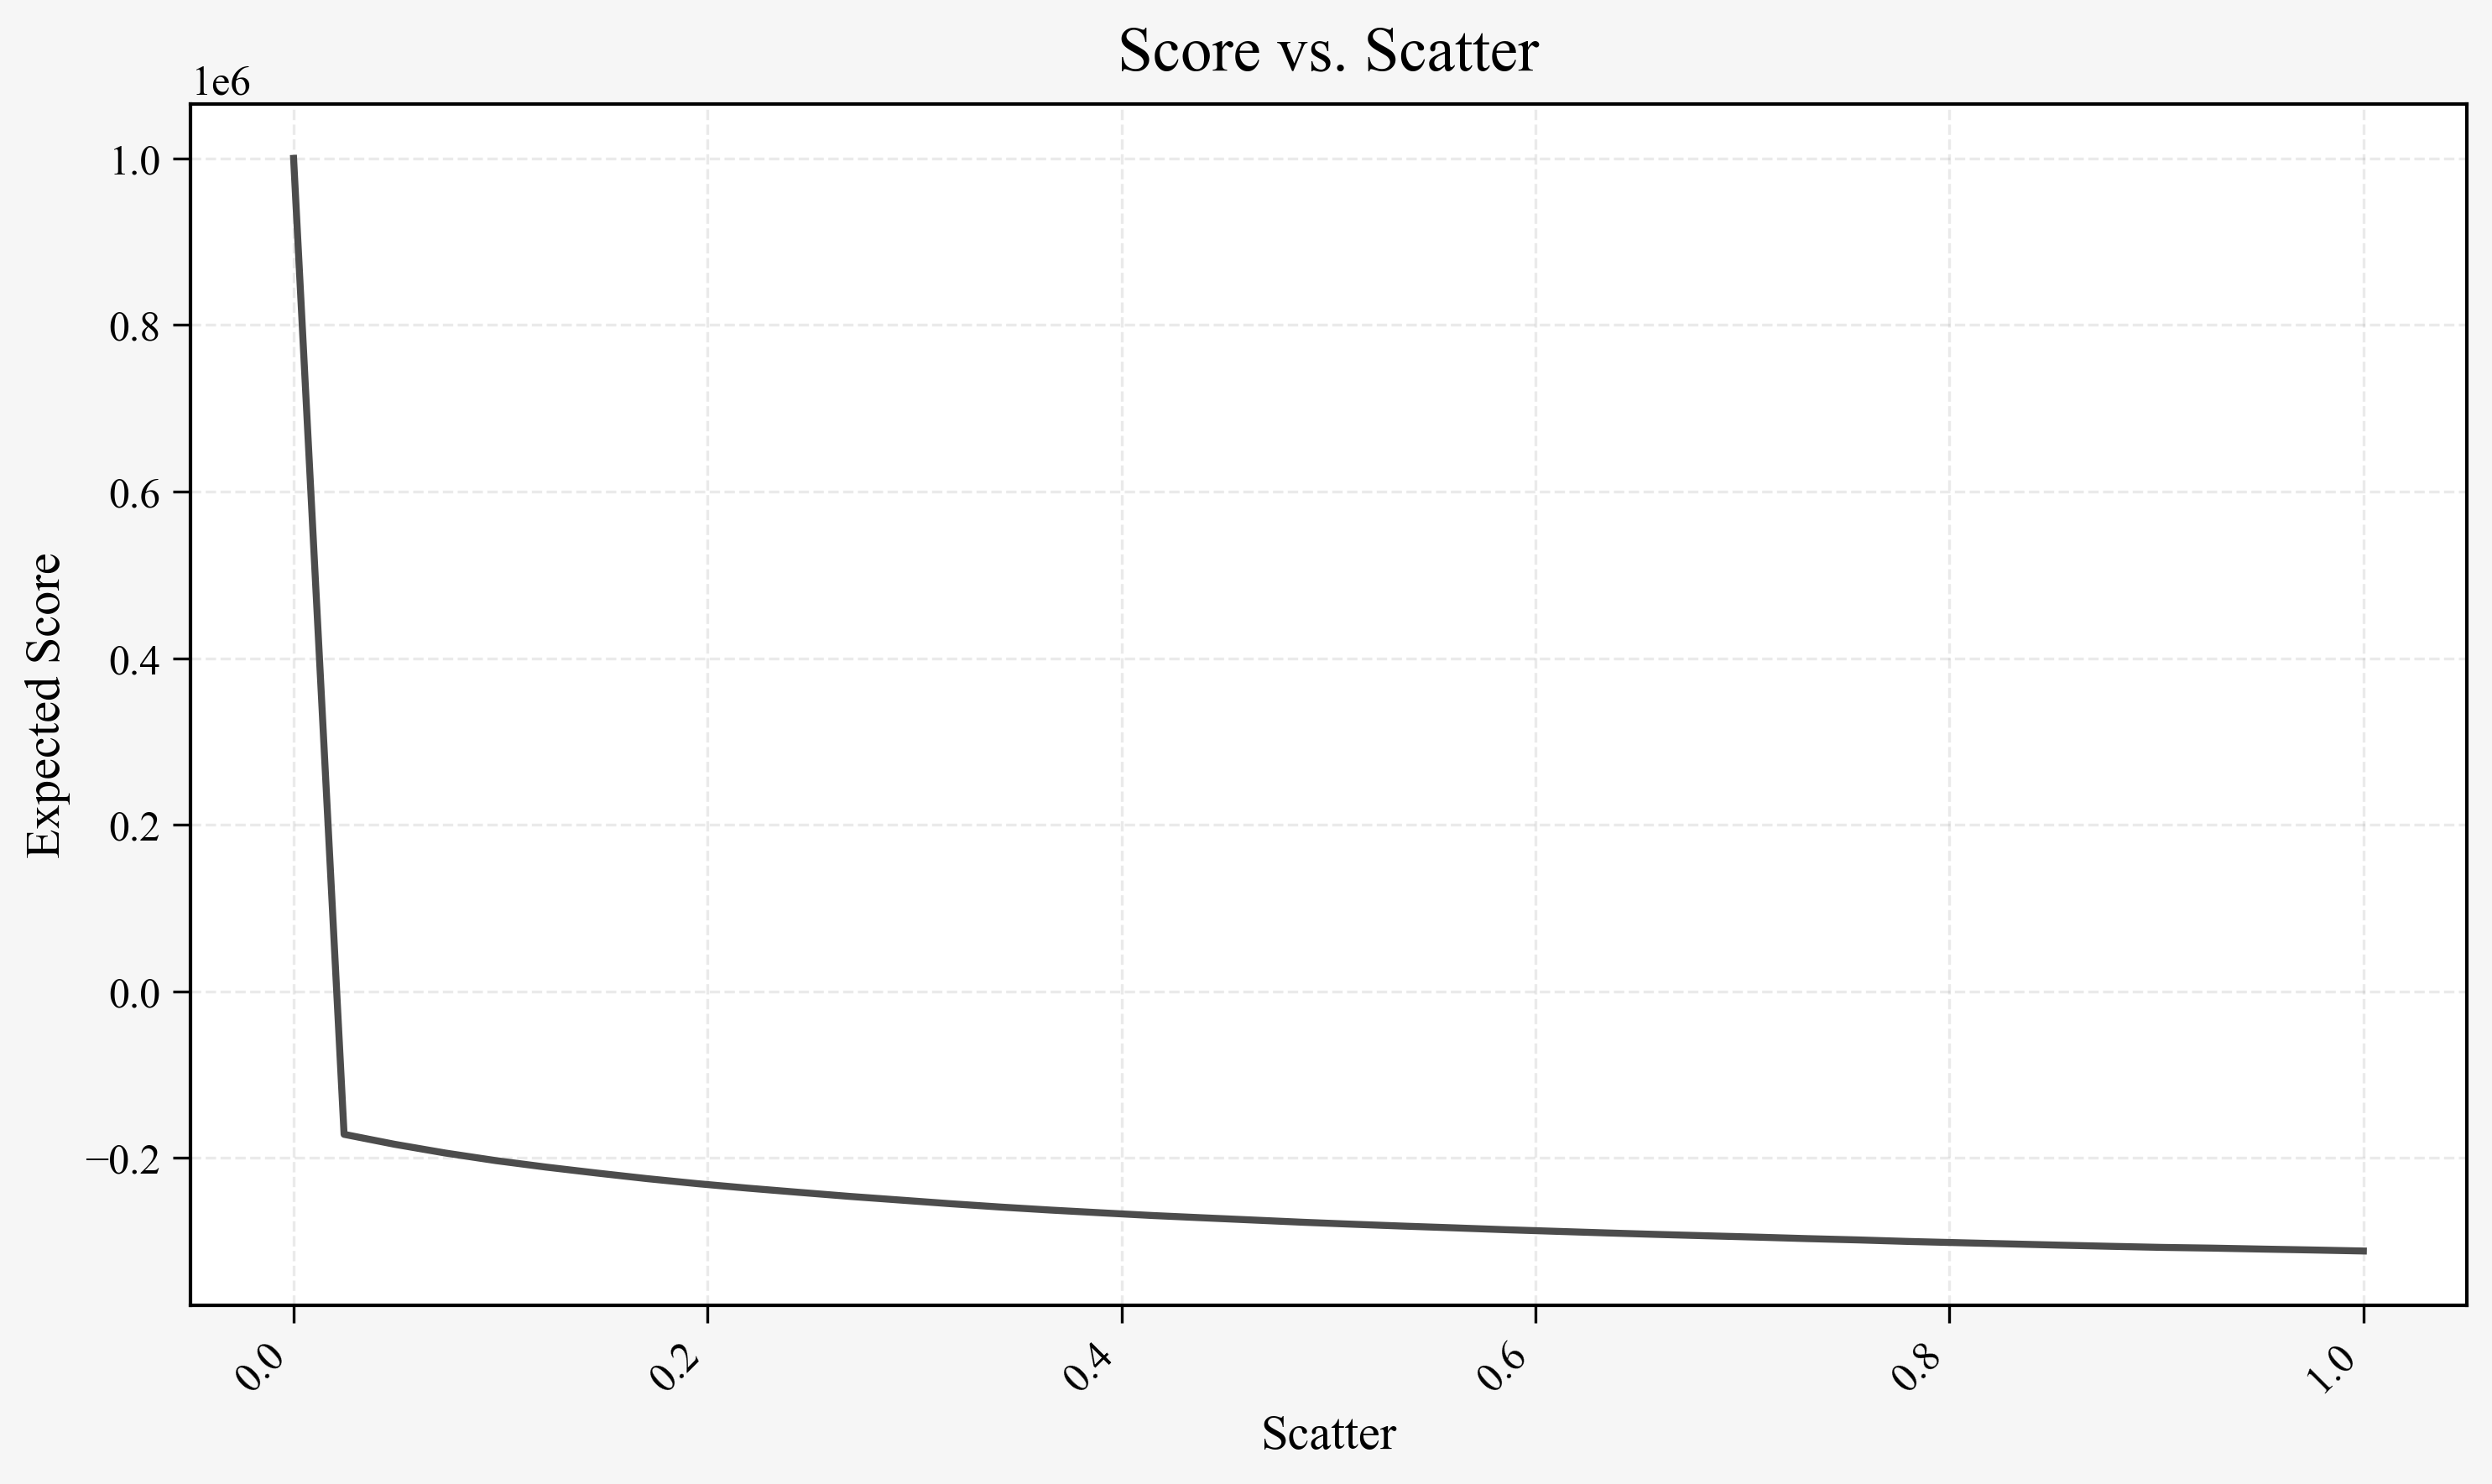

In [108]:
plot_expected_score_by_param(
    df,
    params='scatter',
    figsize=(10,6),
    colors=['#4C4C4C'],
    linestyles=['-','--'],
    linewidths=[2,2],
    Title="Score vs. Scatter",
    XAxis="Scatter"
)

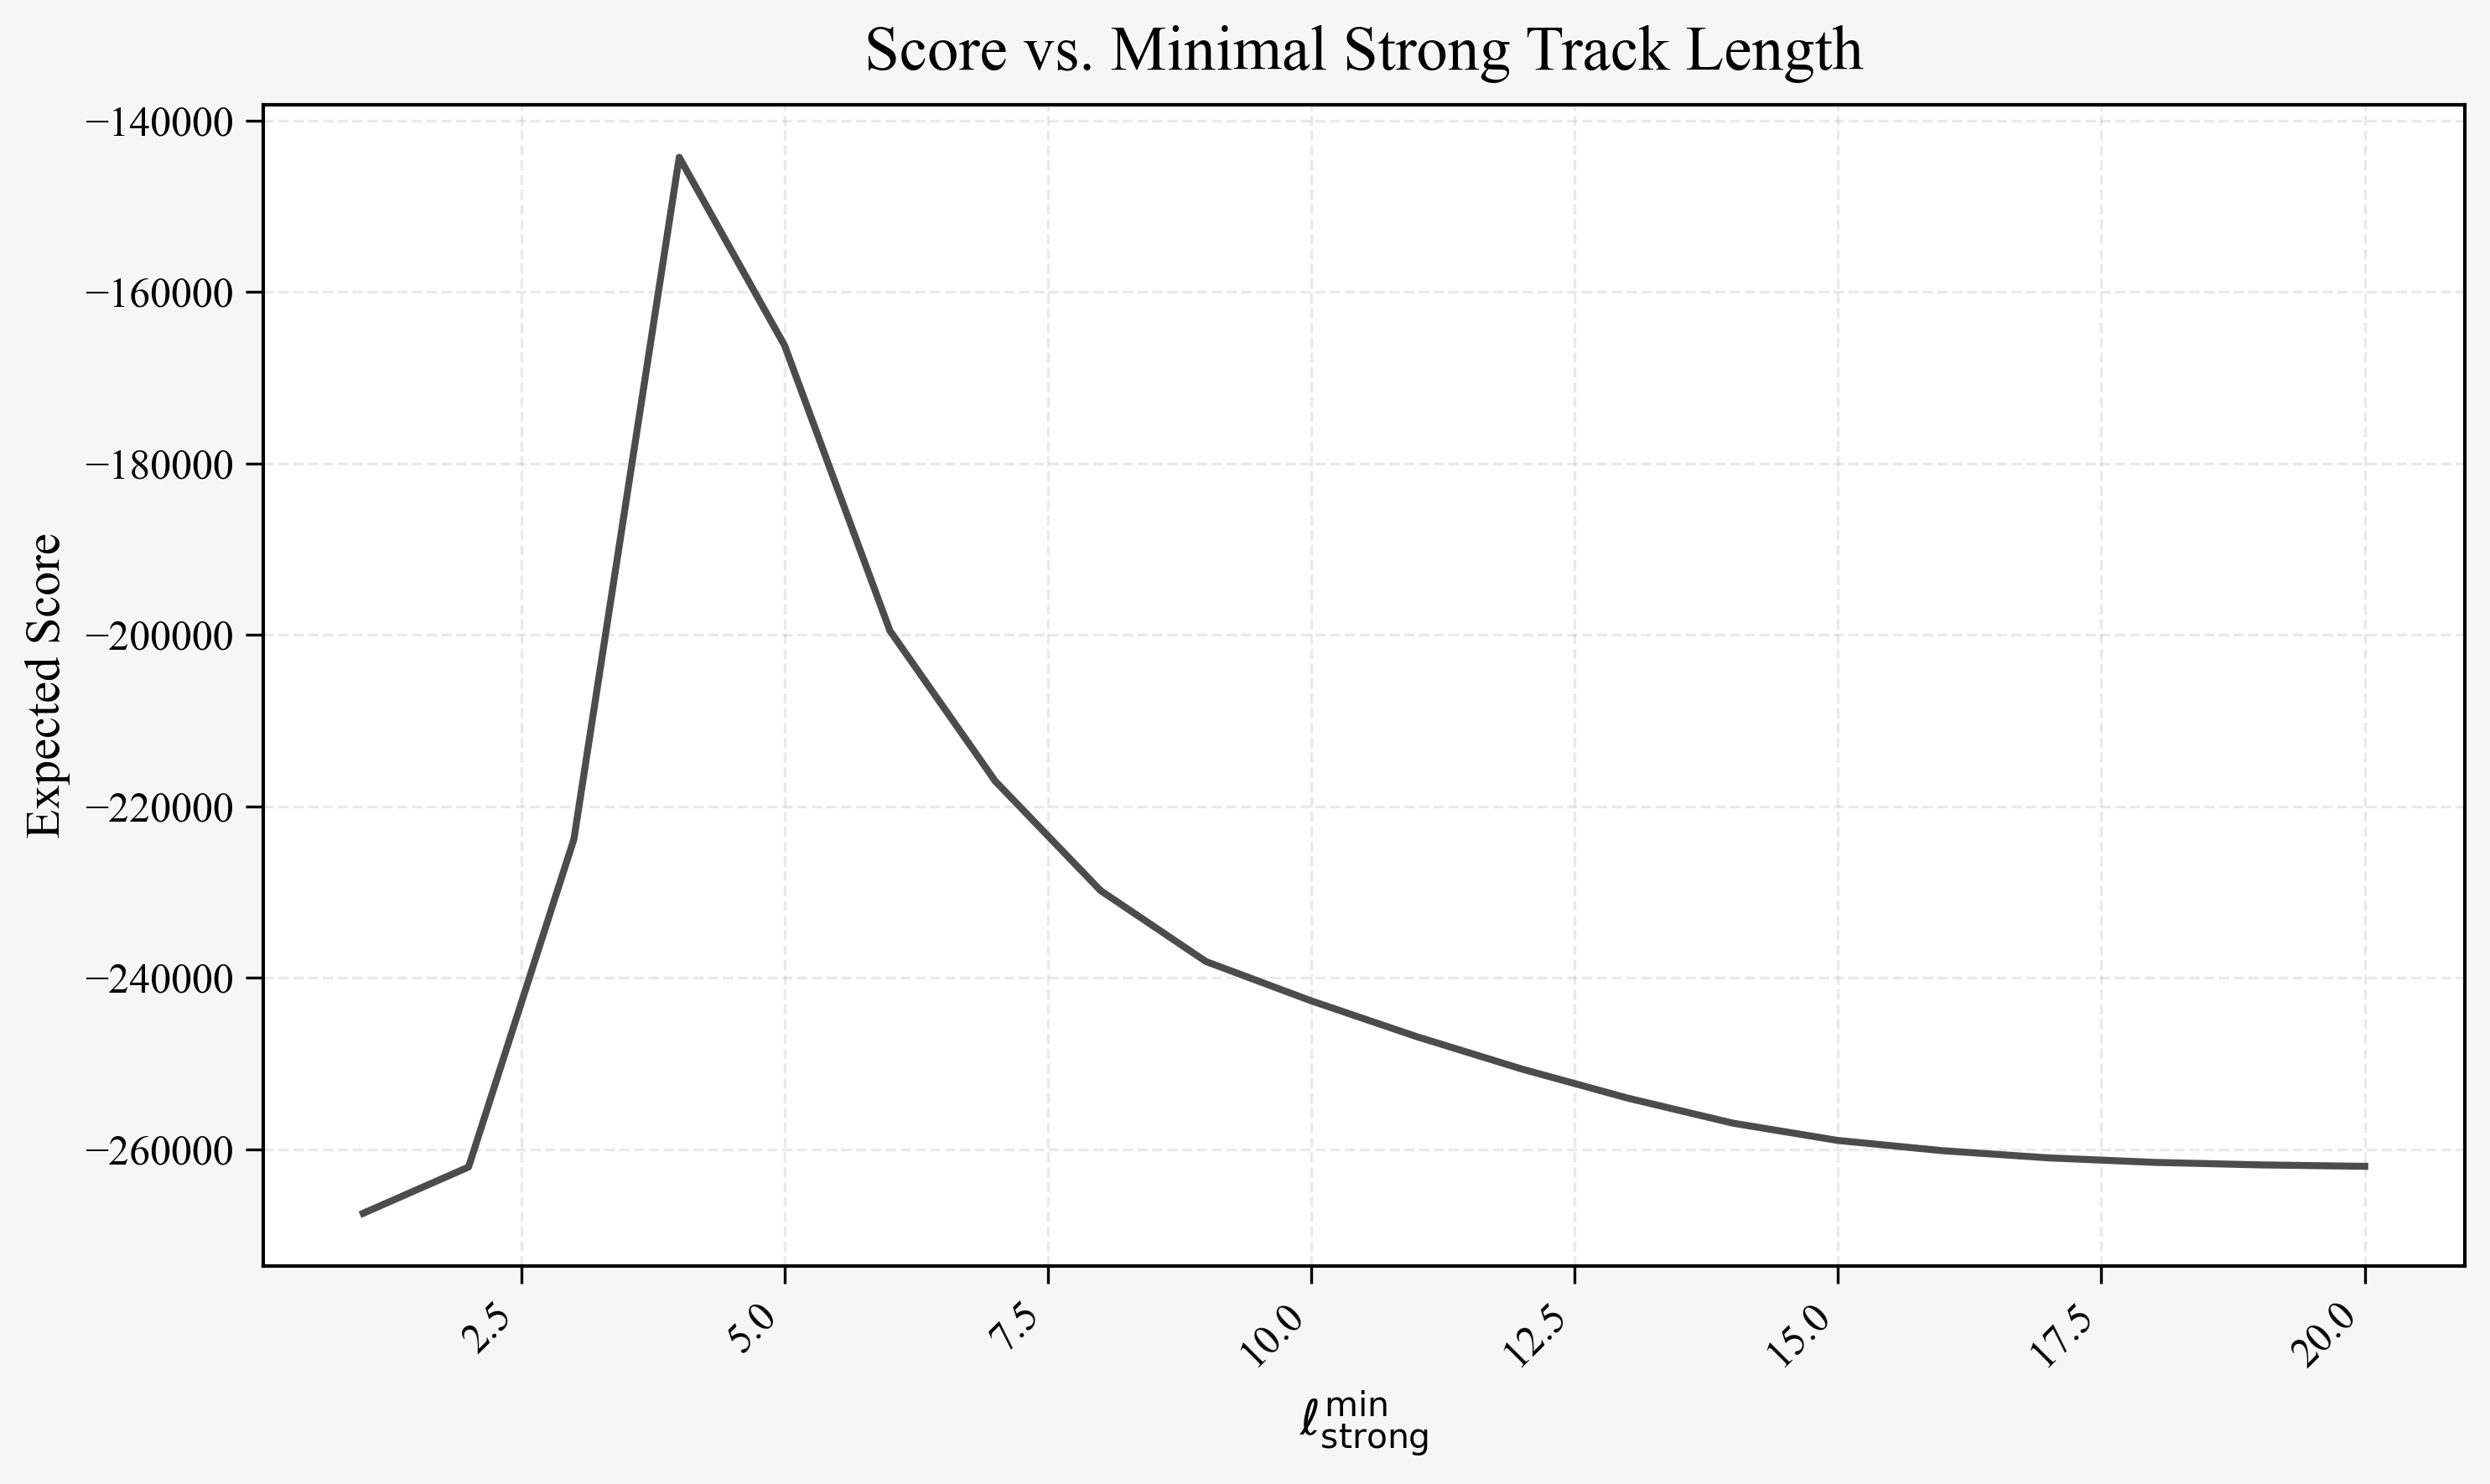

In [109]:
plot_expected_score_by_param(
    df,
    params='min_strong_track_length',
    figsize=(10,6),
    colors=['#4C4C4C'],
    linestyles=['-','--'],
    linewidths=[2,2],
    Title="Score vs. Minimal Strong Track Length",
    XAxis=r"$\ell_{\mathrm{strong}}^{\min}$"
)

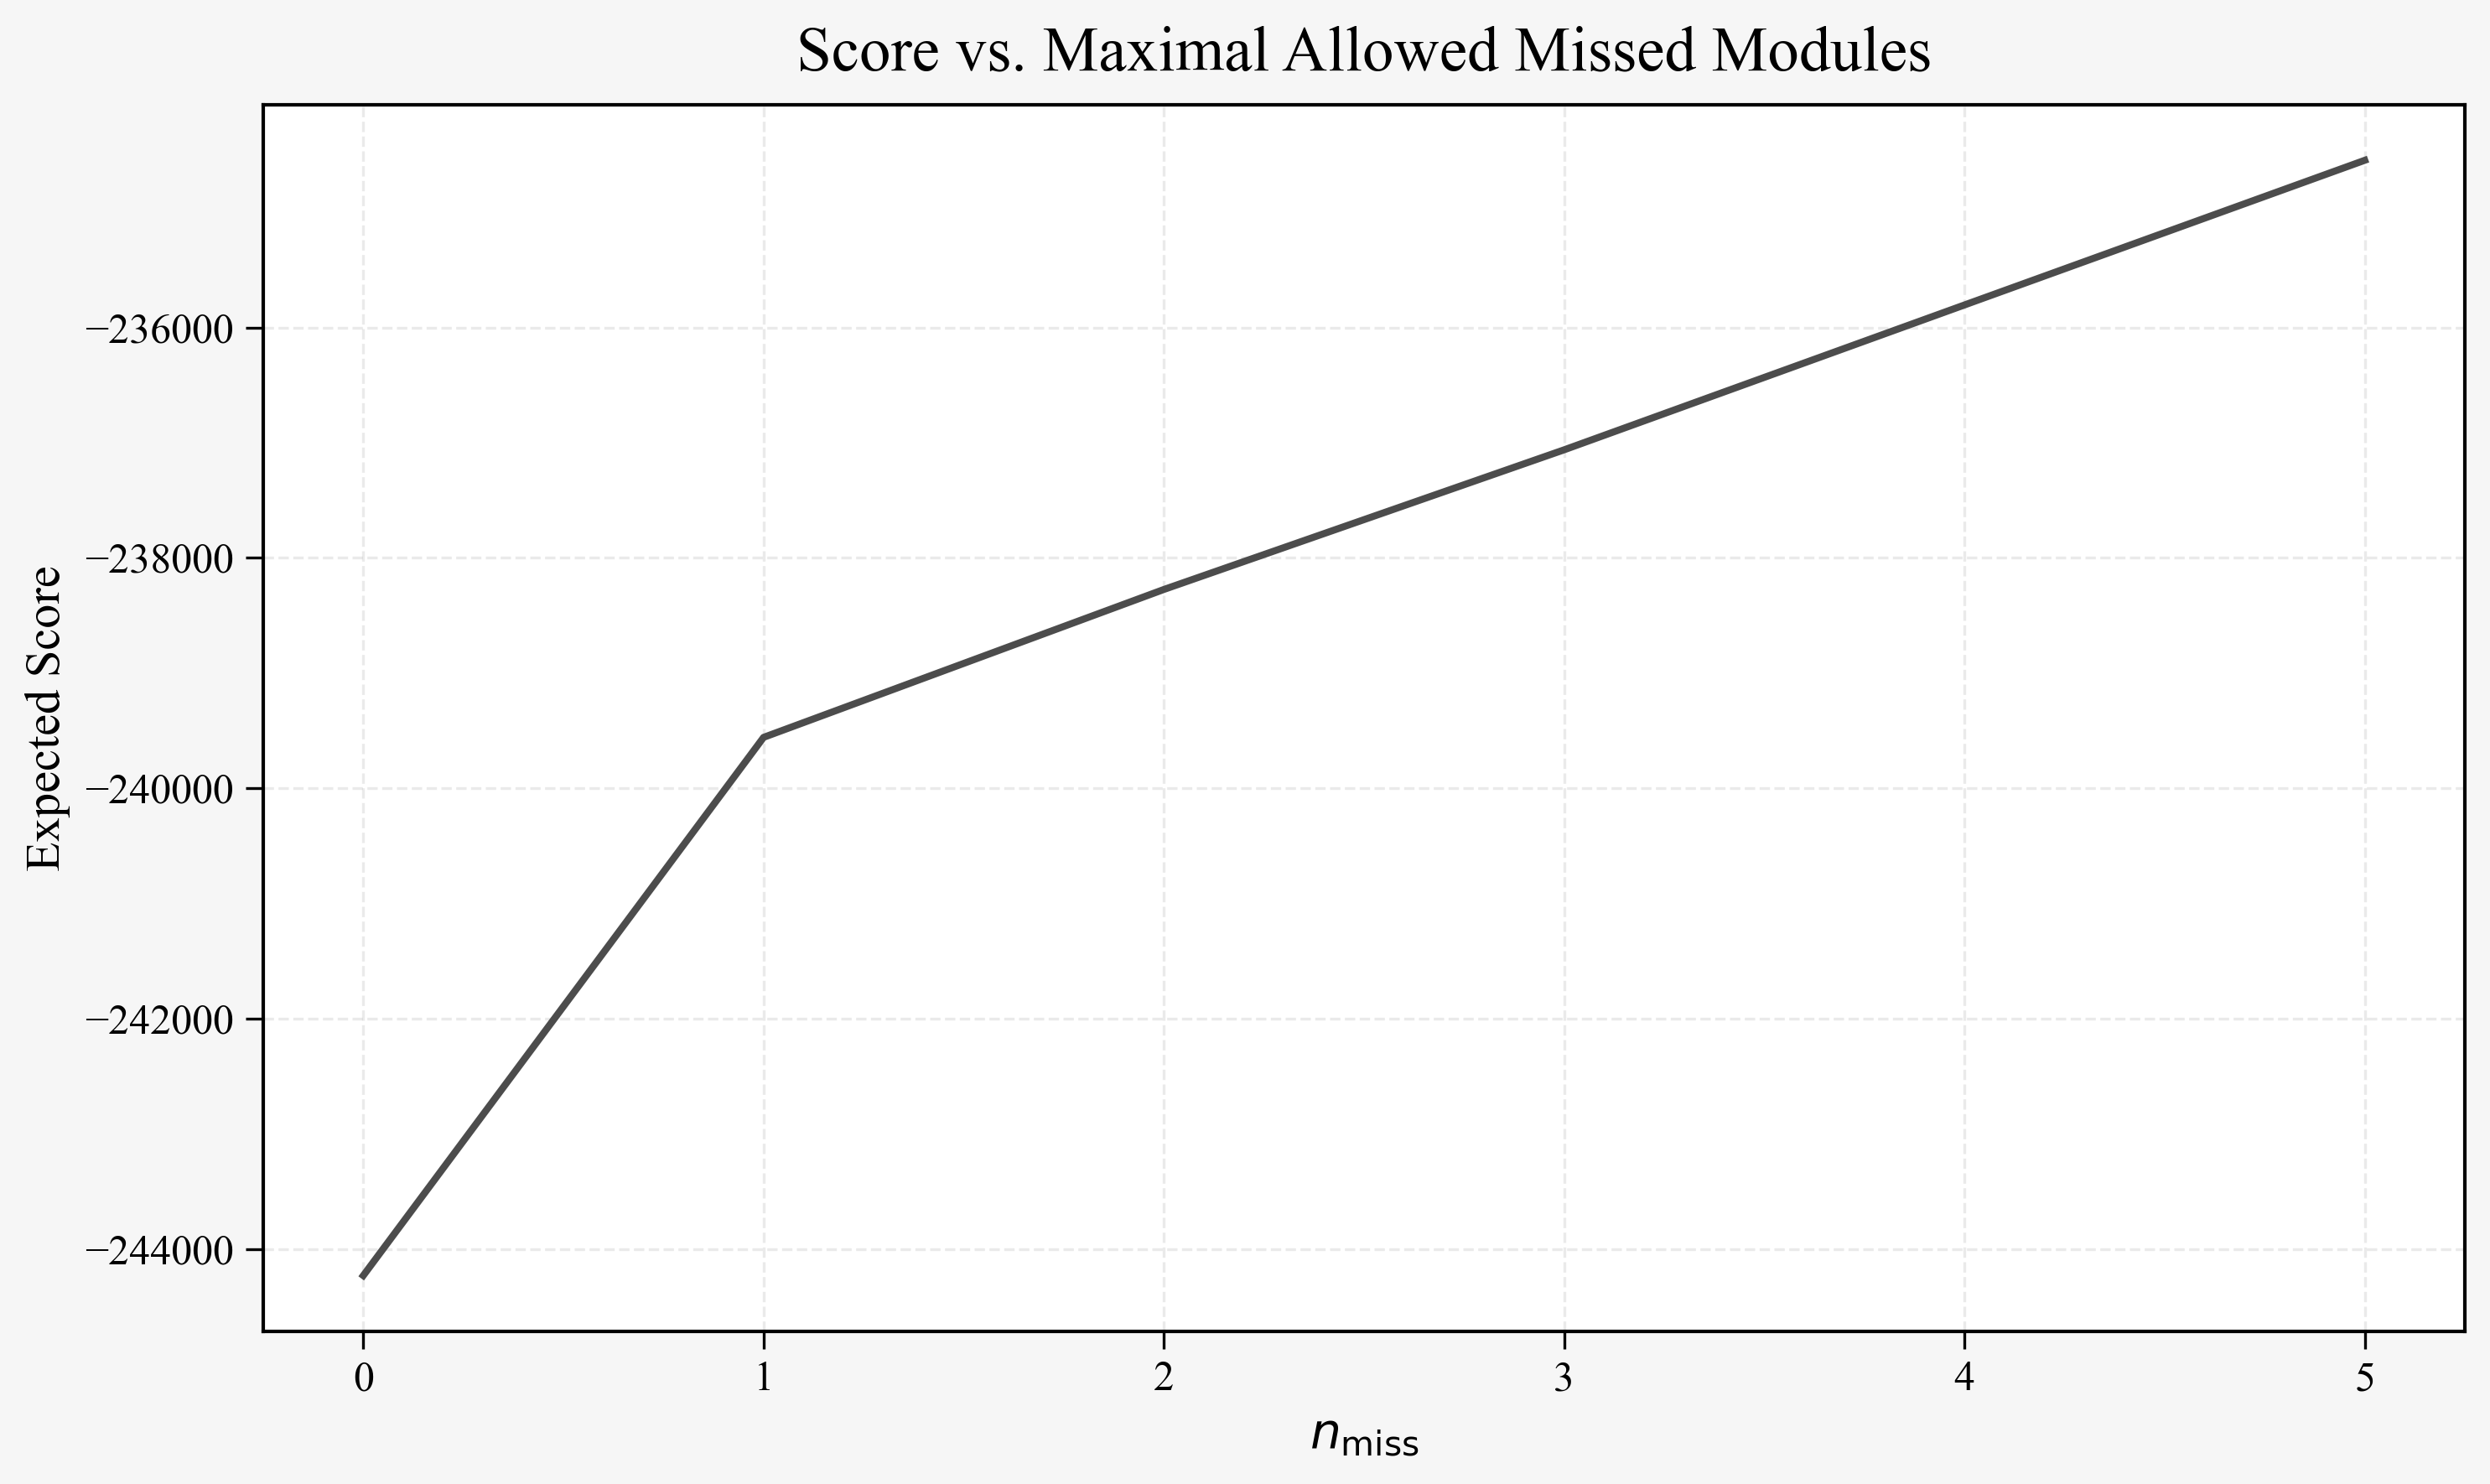

In [110]:
plot_expected_score_by_param(
    df,
    params='allowed_missed_modules',
    figsize=(10,6),
    colors=['#4C4C4C'],
    linestyles=['-','--'],
    linewidths=[2,2],
    Title="Score vs. Maximal Allowed Missed Modules",
    XAxis=r"$n_{\mathrm{miss}}$"
)

## Print the best set of params

In [111]:
df[df['score'] == df['score'].min()]

id          score  total_ghosts  \
5040  505a6e6f-e1a6-4851-aad7-d0483cb5a12f -358631.666824         41724   

      overall_ghost_rate  event_avg_ghost_rate  clone_percentage  \
5040            58.16813             52.240786          2.819223   

      total_tracks      time  scatter  min_strong_track_length  \
5040         71730  0.815418      1.0                      1.0   

      allowed_missed_modules  
5040                     0.0

# Plot hit map

In [112]:
def plot_score_scatter_by_params(
    df,
    x_param,
    y_param,
    figsize=(8, 5),
    cmap='viridis',
    marker='o',
    alpha=0.8,
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    cbar_label='Score',
    dpi=300,
    title="INSERT A TITLE",
    XTitle="INSERT",
    YTitle="INSERT"
):
    """
    Scatter plot of score as color vs two hyperparameters.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing 'score' and hyperparameter columns.
    x_param : str
        Column name for x-axis.
    y_param : str
        Column name for y-axis.
    figsize : tuple, default=(8, 5)
        Figure size in inches.
    cmap : str or Colormap, default='viridis'
        Colormap for score values.
    marker : str, default='o'
        Marker style.
    alpha : float, default=0.8
        Alpha blending for markers.
    title_fontsize, label_fontsize, tick_fontsize, dpi : int
        Matplotlib styling parameters.
    cbar_label : str, default='Score'
        Label for the colorbar.
    """
    # Configure rcParams for publication-quality styling
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "figure.dpi":        dpi,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    fig, ax = plt.subplots(figsize=figsize)
    sc = ax.scatter(
        df[x_param],
        df[y_param],
        c=df['score'],
        cmap=cmap,
        marker=marker,
        alpha=alpha
    )
    ax.set_title(title, pad=10)
    ax.set_xlabel(XTitle)
    ax.set_ylabel(YTitle)

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(cbar_label)

    # Rotate tick labels if needed
    if df[x_param].nunique() > 10:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    if df[y_param].nunique() > 10:
        plt.setp(ax.get_yticklabels(), rotation=45, va='top')

    plt.tight_layout()
    plt.show()



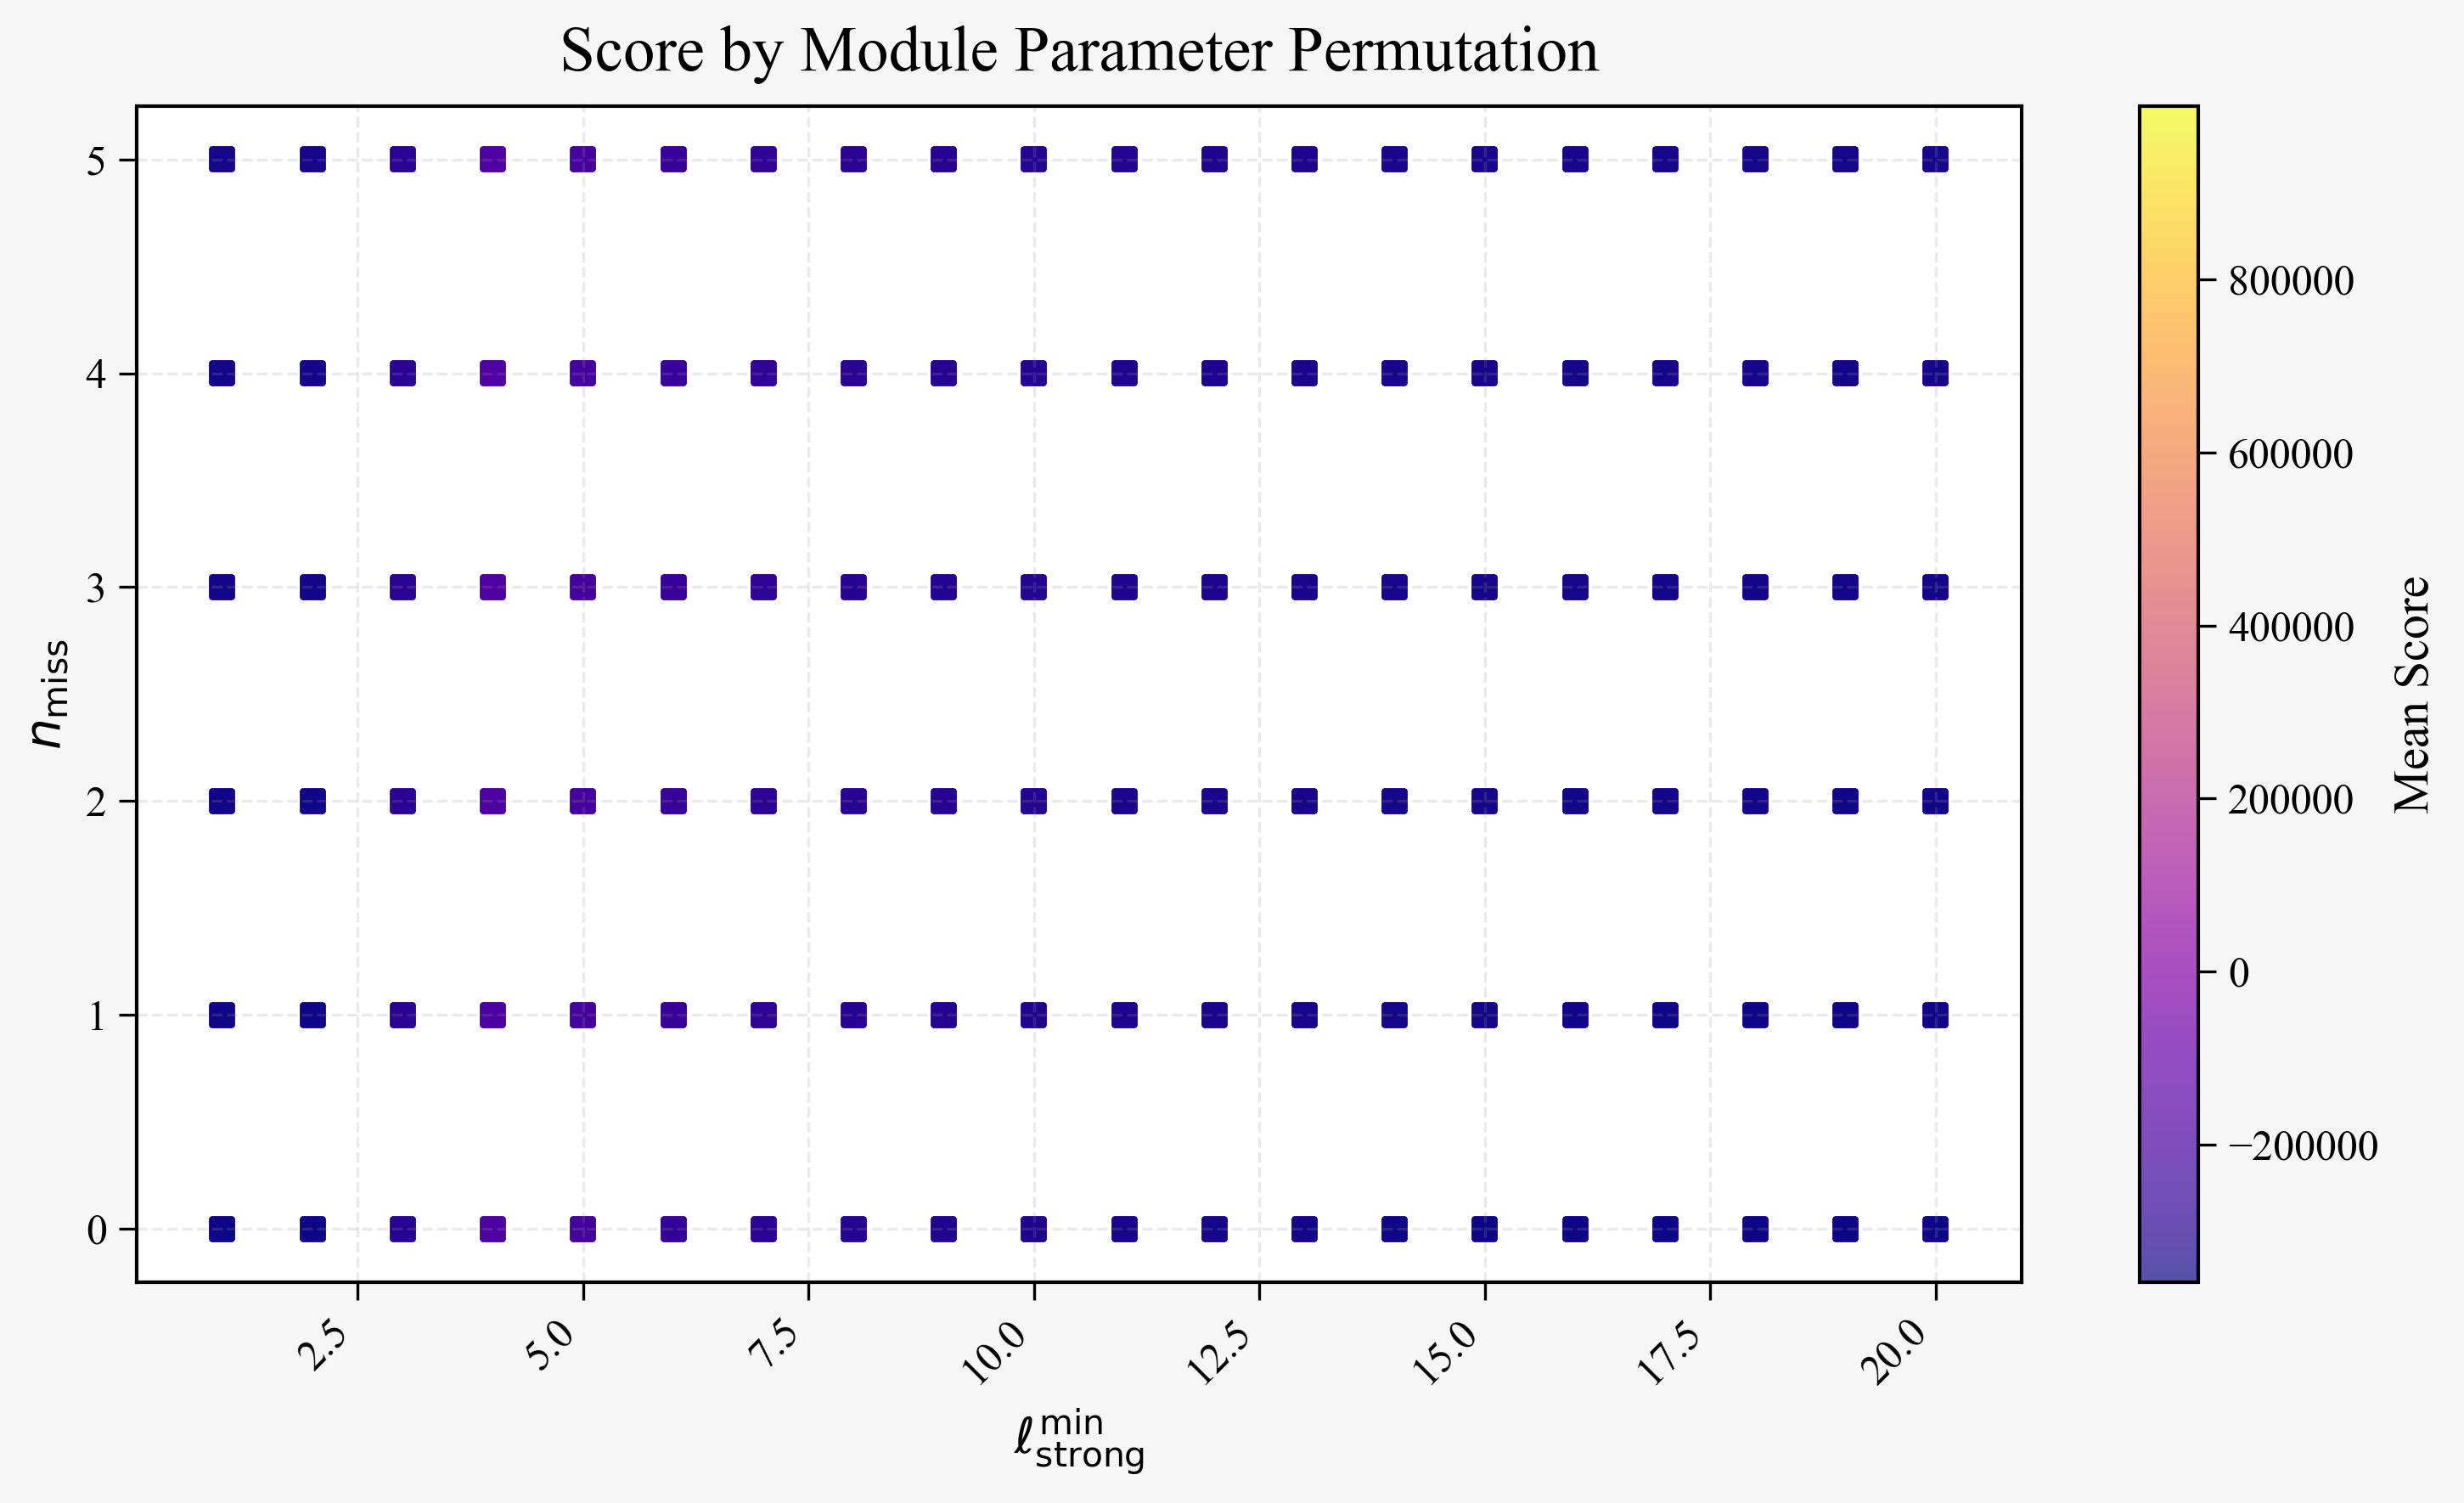

In [113]:
plot_score_scatter_by_params(
    df,
    x_param='min_strong_track_length',
    y_param='allowed_missed_modules',
    figsize=(10, 6),
    cmap='plasma',
    marker='s',
    alpha=0.7,
    cbar_label='Mean Score',
    title="Score by Module Parameter Permutation",
    XTitle=r"$\ell_{\mathrm{strong}}^{\min}$",
    YTitle=r"$n_{\mathrm{miss}}$"
)

In [114]:
def plot_score_landscape(
    df,
    x_param,
    y_param,
    figsize=(8, 5),
    cmap='viridis',
    alpha=0.8,
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    cbar_label='Score',
    dpi=300,
    title="INSERT A TITLE",
    XTitle="INSERT",
    YTitle="INSERT",
    resolution=100,
    show_scatter=True
):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import griddata

    # Drop rows with NaNs in relevant columns
    df_clean = df[[x_param, y_param, 'score']].dropna()

    x = df_clean[x_param].values
    y = df_clean[y_param].values
    z = df_clean['score'].values

    # Grid for interpolation
    xi = np.linspace(x.min(), x.max(), resolution)
    yi = np.linspace(y.min(), y.max(), resolution)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate: Try 'cubic' but fallback to 'linear' if it fails
    try:
        zi = griddata((x, y), z, (xi, yi), method='cubic')
    except Exception as e:
        print("Cubic interpolation failed, falling back to linear:", e)
        zi = griddata((x, y), z, (xi, yi), method='linear')

    # Setup plot
    plt.rcParams.update({
        "figure.facecolor":   "#F6F6F6",  # <- Correct key with hex
        "axes.facecolor":     "#FFFFFF",
        "font.family": "serif",
        "axes.titlesize": title_fontsize,
        "axes.labelsize": label_fontsize,
        "xtick.labelsize": tick_fontsize,
        "ytick.labelsize": tick_fontsize,
        "figure.dpi": dpi,
        "axes.grid": True,
        "grid.color": "#999999",
        "grid.alpha": 0.2,
        "grid.linestyle": "--"
    })

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.contourf(xi, yi, zi, levels=100, cmap=cmap, alpha=alpha)

    if show_scatter:
        sc = ax.scatter(x, y, c=z, cmap=cmap, edgecolor='k', marker='o', alpha=1.0)

    ax.set_title(title)
    ax.set_xlabel(XTitle)
    ax.set_ylabel(YTitle)
    ax.set_xlim(0,0.1)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)

    plt.tight_layout()
    plt.show()


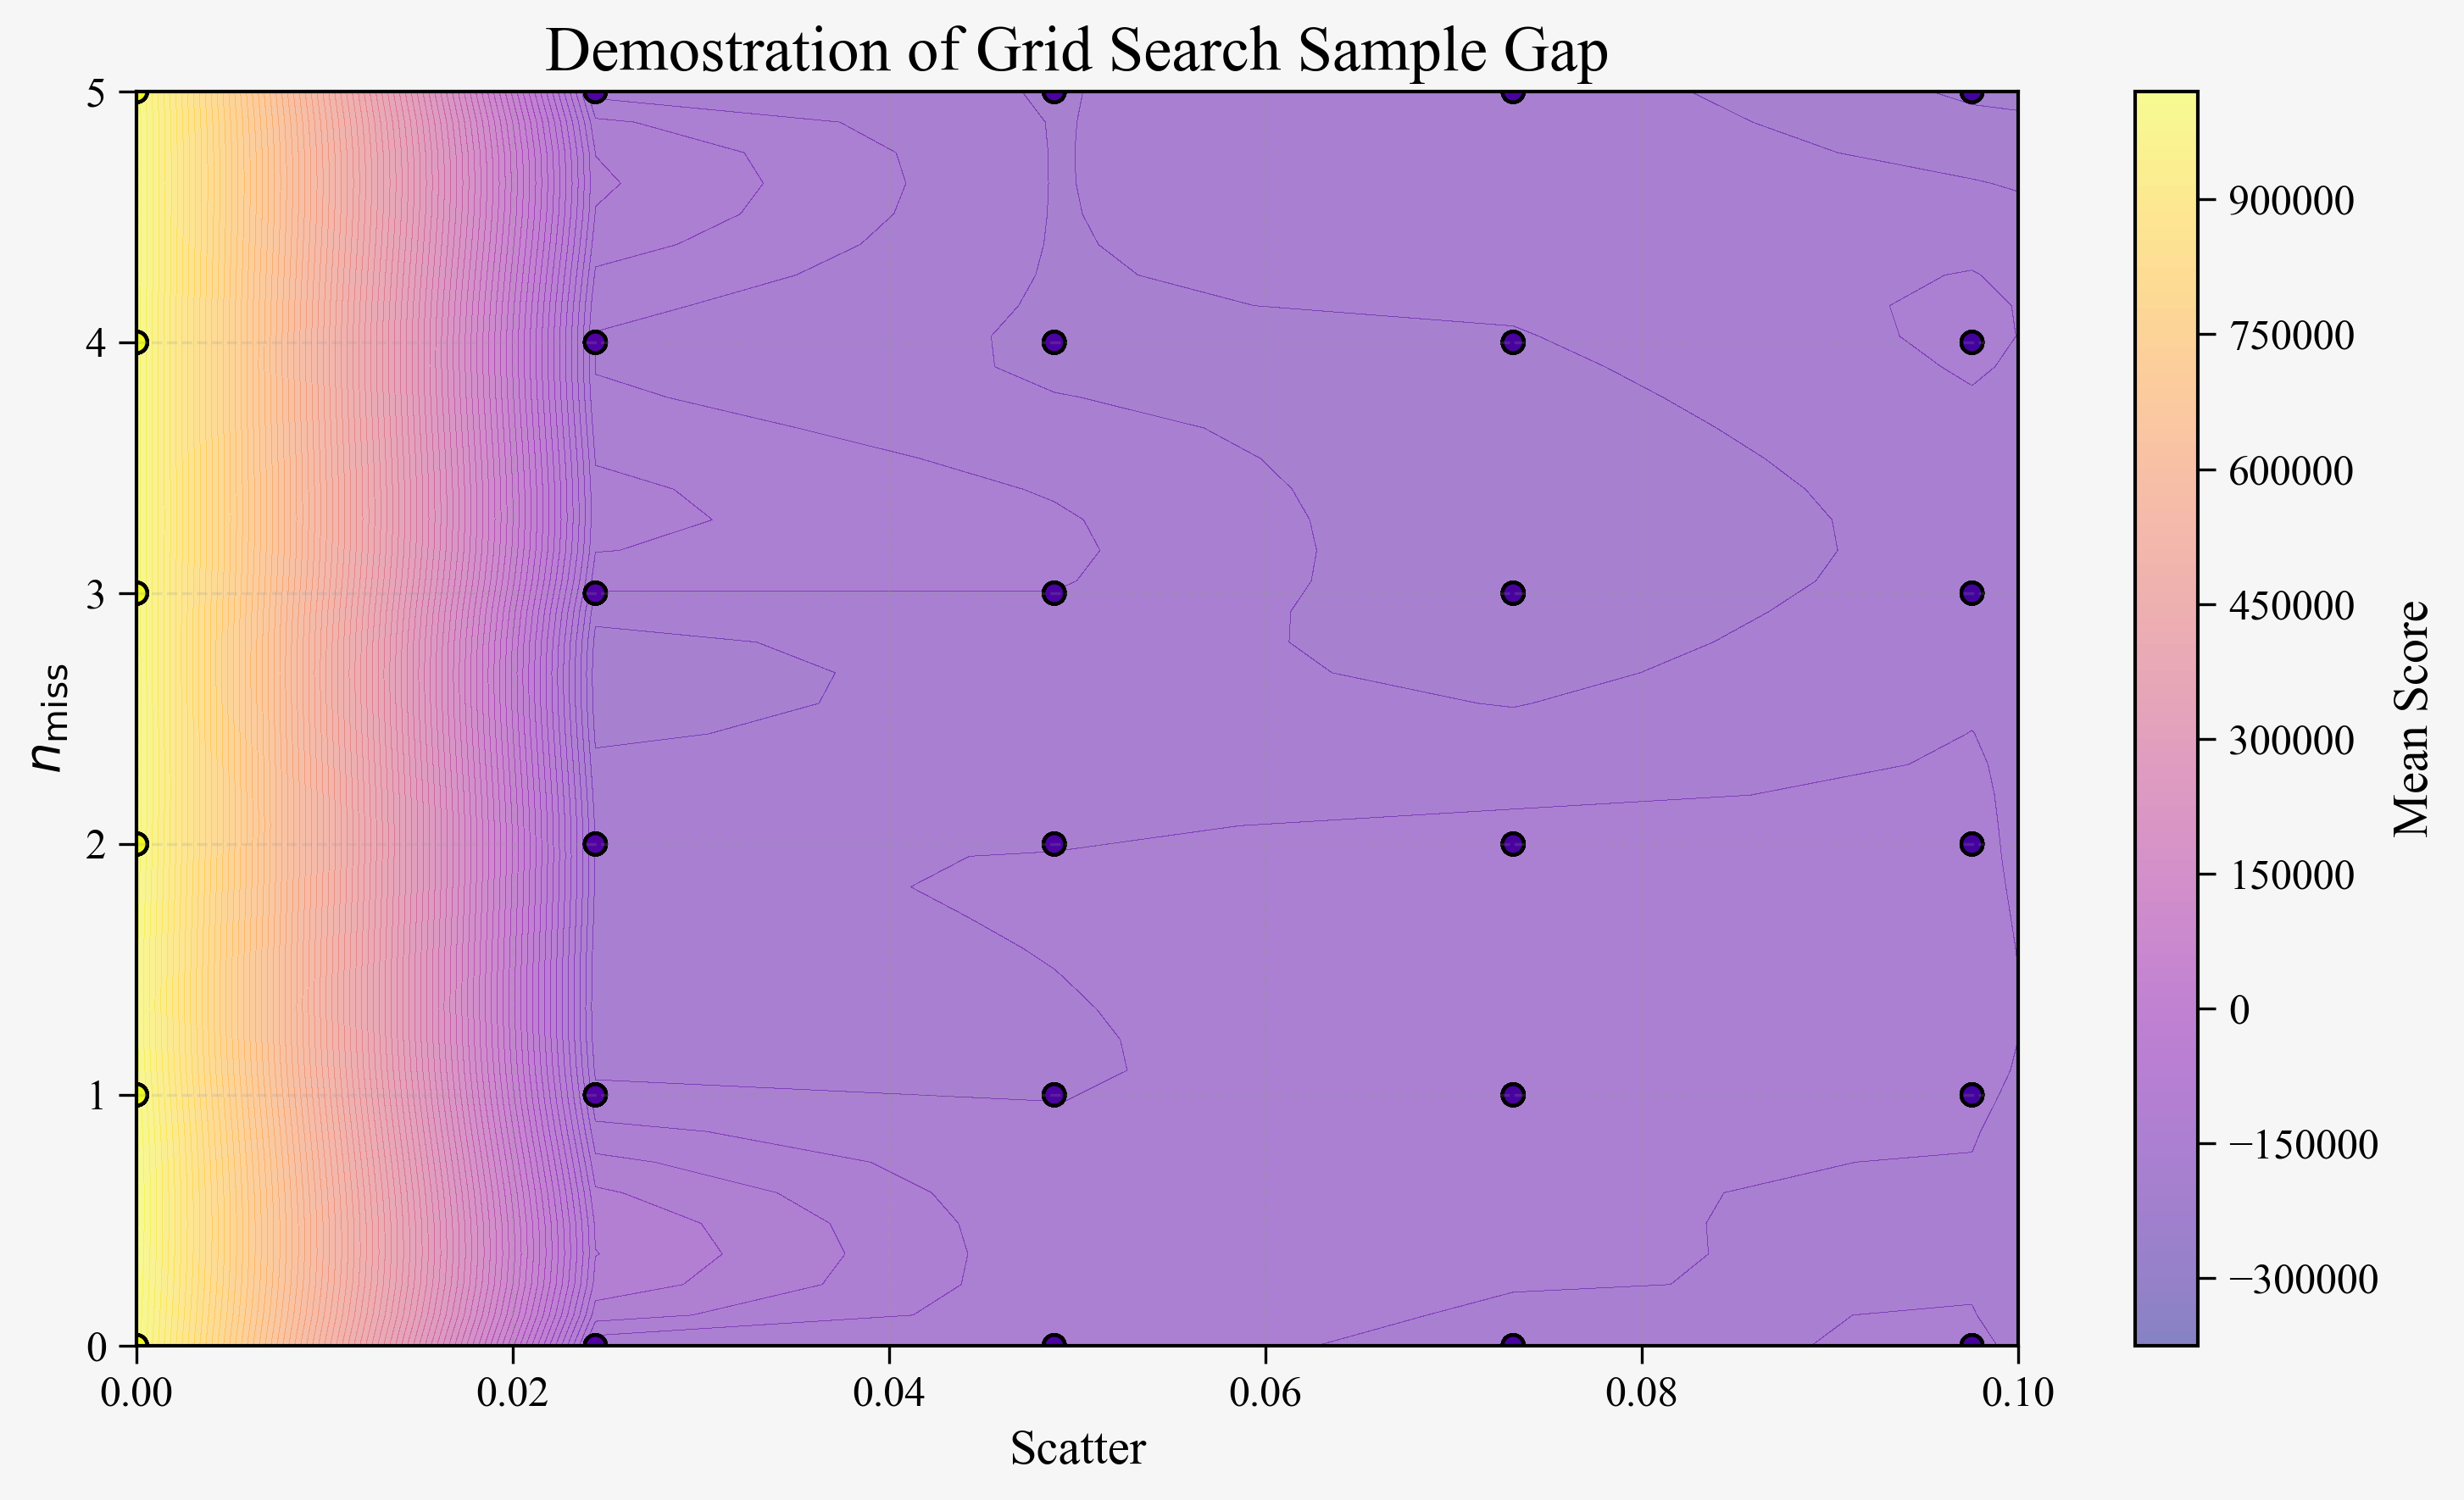

In [116]:
plot_score_landscape(
    df,
    x_param='scatter',
    y_param='allowed_missed_modules',
    figsize=(10, 6),
    cmap='plasma',
    alpha=0.5,
    cbar_label='Mean Score',
    title="Demostration of Grid Search Sample Gap",
    XTitle=r"Scatter",
    YTitle=r"$n_{\mathrm{miss}}$",
    resolution=configuration["optimizer"]["resolution"],       # You can increase for smoother interpolation
    show_scatter=True,     # Set to False if you want only the interpolated surface
)


In [120]:
def plot_score_landscape2(
    df,
    x_param,
    y_param,
    figsize=(8, 5),
    cmap='viridis',
    alpha=0.8,
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    cbar_label='Score',
    dpi=300,
    title="INSERT A TITLE",
    XTitle="INSERT",
    YTitle="INSERT",
    resolution=100,
    show_scatter=True
):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import griddata
    from matplotlib.patches import Rectangle

    # Drop rows with NaNs in relevant columns
    df_clean = df[[x_param, y_param, 'score']].dropna()

    x = df_clean[x_param].values
    y = df_clean[y_param].values
    z = df_clean['score'].values

    # Grid for interpolation
    xi = np.linspace(x.min(), x.max(), resolution)
    yi = np.linspace(y.min(), y.max(), resolution)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate: Try 'cubic' but fallback to 'linear' if it fails
    try:
        zi = griddata((x, y), z, (xi, yi), method='cubic')
    except Exception as e:
        print("Cubic interpolation failed, falling back to linear:", e)
        zi = griddata((x, y), z, (xi, yi), method='linear')

    # Setup plot style
    plt.rcParams.update({
        "figure.facecolor": "#F6F6F6",
        "axes.facecolor": "#FFFFFF",
        "font.family": "serif",
        "axes.titlesize": title_fontsize,
        "axes.labelsize": label_fontsize,
        "xtick.labelsize": tick_fontsize,
        "ytick.labelsize": tick_fontsize,
        "figure.dpi": dpi,
        "axes.grid": True,
        "grid.color": "#999999",
        "grid.alpha": 0.2,
        "grid.linestyle": "--"
    })

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.contourf(xi, yi, zi, levels=100, cmap=cmap, alpha=alpha)

    if show_scatter:
        ax.scatter(x, y, c=z, cmap=cmap, edgecolor='k', marker='o', alpha=1.0)

    ax.set_title(title)
    ax.set_xlabel(XTitle)
    ax.set_ylabel(YTitle)
    ax.set_xlim(0, 0.1)

    # Add gray "No Data" region to the left of x.min()
    # no_data_x_end = x.min()
    no_data_x_end = 0.024390243902439025
    # print(x.min())
    ax.add_patch(Rectangle(
        (0, ax.get_ylim()[0]),
        width=no_data_x_end,
        height=ax.get_ylim()[1] - ax.get_ylim()[0],
        color='gray',
        alpha=0.15,
        zorder=0
    ))
    ax.add_patch(Rectangle(
        (0, ax.get_ylim()[0]),
        width=no_data_x_end,
        height=ax.get_ylim()[1] - ax.get_ylim()[0],
        fill=False,
        hatch='////',
        edgecolor='#3D58DD',
        linewidth=0.0,
        zorder=1
    ))
    ax.text(
        0.5 * no_data_x_end,
        0.5 * (ax.get_ylim()[0] + ax.get_ylim()[1]),
        r"No Data",
        color="black",
        fontsize=label_fontsize + 2,
        ha='center',
        va='center',
        fontweight='bold',
        rotation=0,
        zorder=2,
        bbox=dict(
        facecolor='white',   # Background box color
        edgecolor='none',
        alpha=0.85,
        boxstyle='round,pad=0.2'
    )
    )

    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)

    plt.tight_layout()
    plt.show()


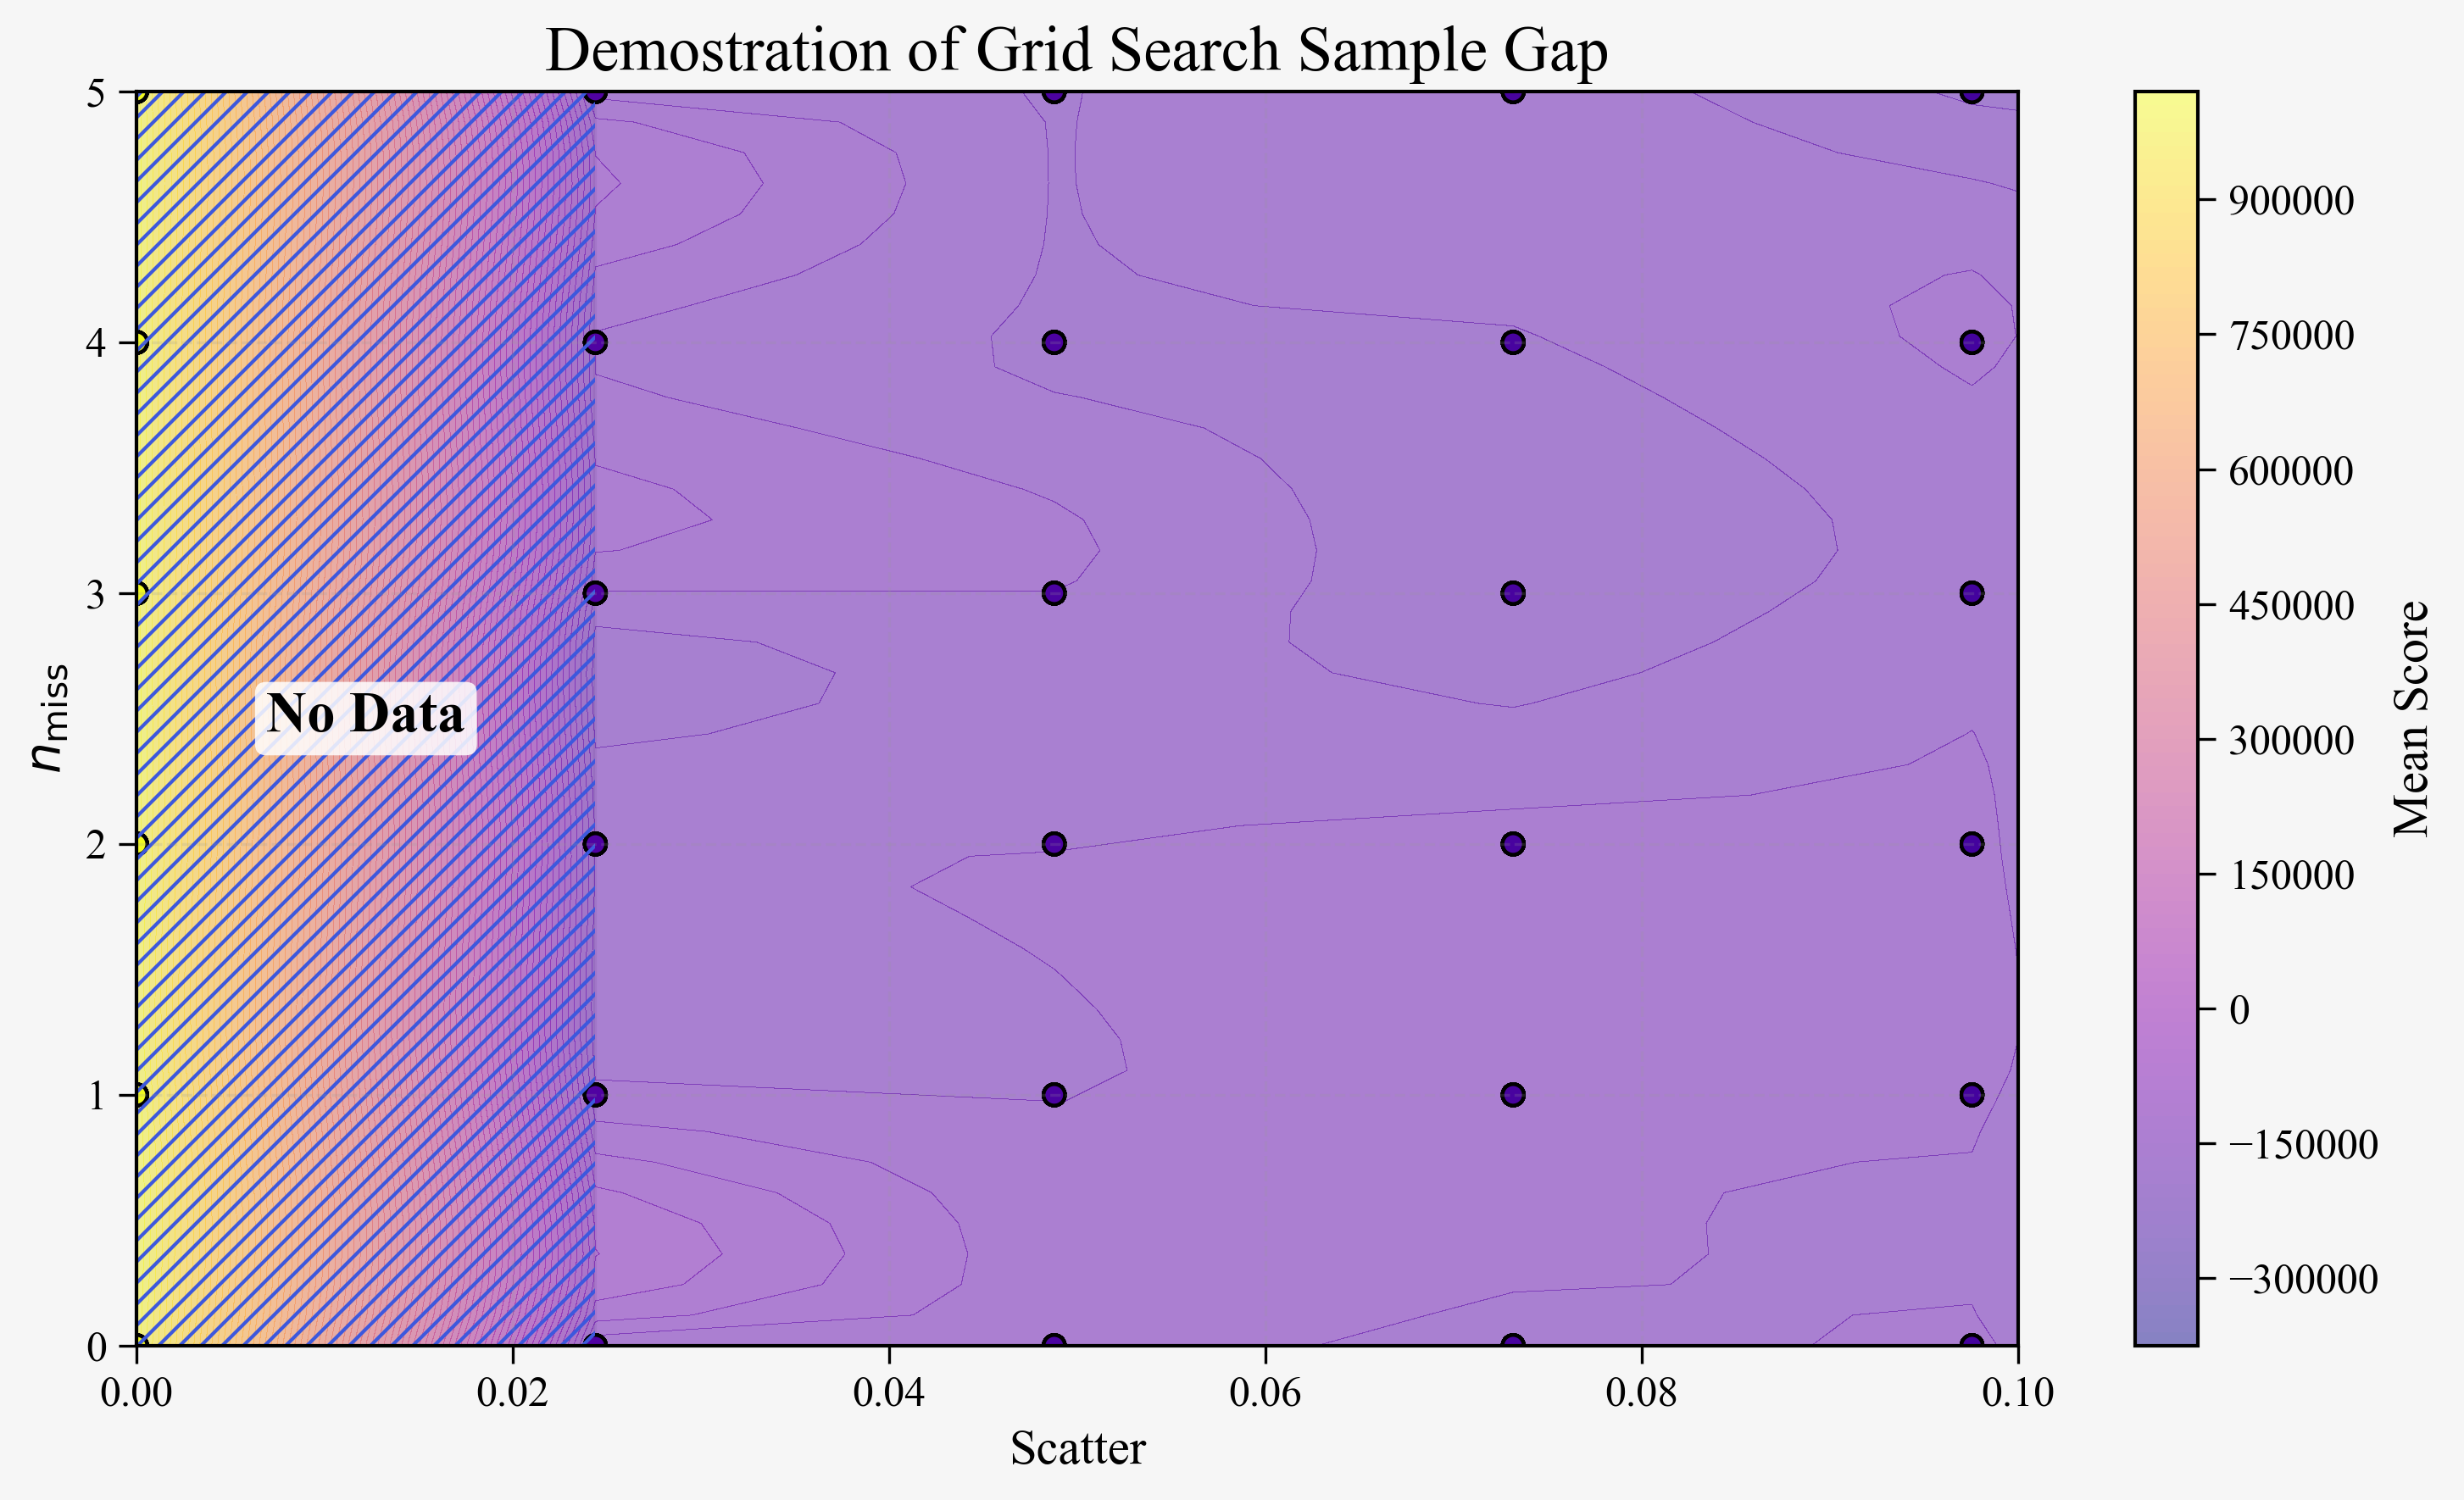

In [121]:
plot_score_landscape2(
    # df[df["scatter"] != 0],
    df,
    x_param='scatter',
    y_param='allowed_missed_modules',
    figsize=(10, 6),
    cmap='plasma',
    alpha=0.5,
    cbar_label='Mean Score',
    title="Demostration of Grid Search Sample Gap",
    XTitle=r"Scatter",
    YTitle=r"$n_{\mathrm{miss}}$",
    resolution=configuration["optimizer"]["resolution"],       # You can increase for smoother interpolation
    show_scatter=True,     # Set to False if you want only the interpolated surface
)


## Lets see how PolyHoot Traverses this "landscape"

In [ ]:
DF_polyhoot = parse_results("results/result_PolyHoot_ST_1_0b334e11-2d73-48cf-a880-c445b415abd3.jsonl")
get_config("results/result_PolyHoot_ST_1_0b334e11-2d73-48cf-a880-c445b415abd3.jsonl")

{'solverName': 'PolyHoot',
 'reconstruction_algo': 'ST',
 'num_events': 100,
 'intra_node': True,
 'max_runs': 1000,
 'optimizer': {'max_iterations': 1000,
  'objective': 'min',
  'nested': True,
  'weights': [0.4, 0.2, 0.5, -7.0]}}

In [ ]:
# take first 200 rows, then drop any duplicate parameter‐pairs (keeping the first occurrence)
DF_polyhoot = (
    DF_polyhoot
    # .head(200)
    .drop_duplicates(
        subset=['min_strong_track_length', 'allowed_missed_modules'],
        keep='first'
    )
).dropna()


In [ ]:
DF_polyhoot.head()

id         score  total_ghosts  \
1  26d932dc-a8f5-4e84-b9c4-de2f2e14a794  24802.200622         18750   
3  4eda1de5-26e7-470e-b43b-72f4f0838fad  18651.647883          6578   
4  03e08b5e-76b0-401f-9013-080ca844cfb4  25856.664743         20825   
5  26d21a1c-9ff9-4c75-9634-cc327ca14fb1  18669.639394          6565   
6  6ee91f47-0a18-4441-b523-b2ce415c7f13  18626.660393          6591   

   overall_ghost_rate  event_avg_ghost_rate  clone_percentage  total_tracks  \
1           37.810805             31.563758          2.992019         49589   
3           17.637280             15.141903          2.833539         37296   
4           40.282802             33.850950          3.001437         51697   
5           17.585449             15.106371          2.830382         37332   
6           17.695860             15.181701          2.836076         37246   

       time  scatter  min_strong_track_length  allowed_missed_modules  
1  0.346153     0.25                     10.0                     2.0  
3  0.301066     0.25                      5.0                     2.0  
4  0.270456     0.25                     15.0                     2.0  
5  0.305760     0.25                      5.0                     1.0  
6  0.303053     0.25                      5.0                     3.0

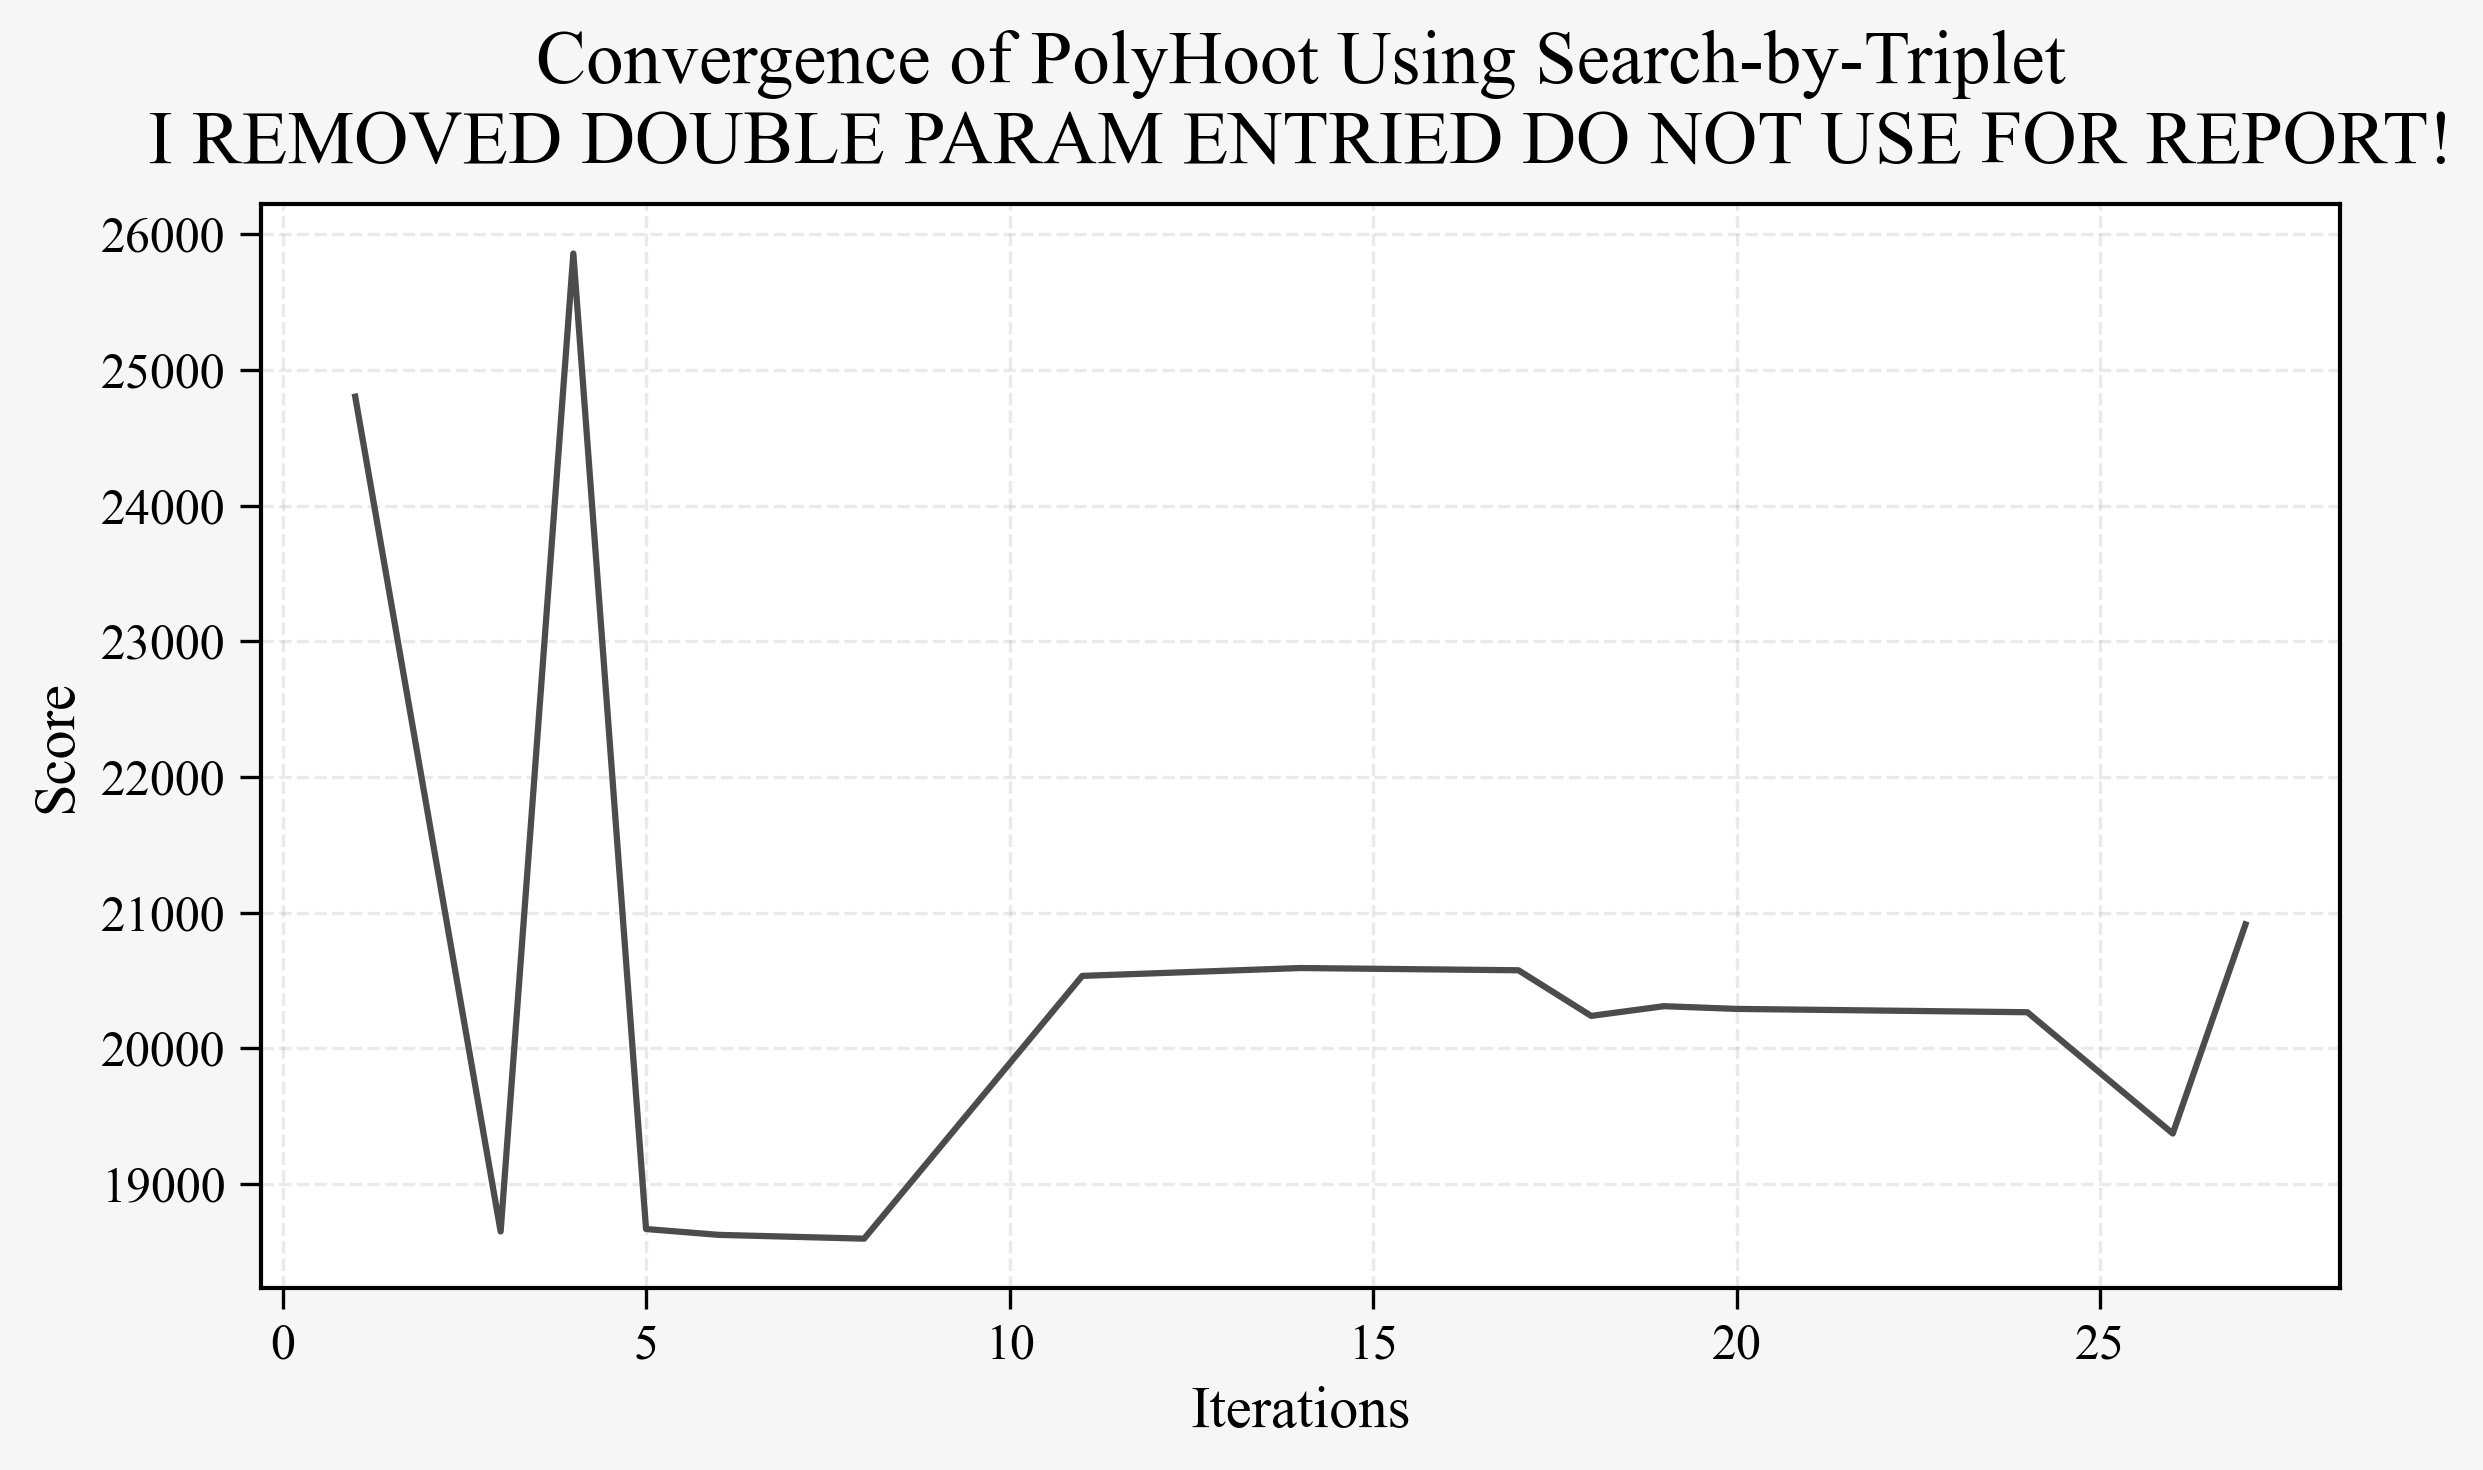

In [ ]:
def plot_convergence(
    df,
    figsize=(8, 5),
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    dpi=300,
    color="#4C4C4C",
    linestyle="-",
    linewidth=1.5
):
    # 1) Configure rcParams
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "figure.dpi":        dpi,
        "axes.linewidth":    1.0,
        "xtick.major.size":  5,
        "ytick.major.size":  5,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    # 2) Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(
        df.index,
        df['score'],
        color=color,
        linestyle=linestyle,
        linewidth=linewidth
    )
    ax.set_title("Convergence of PolyHoot Using Search-by-Triplet\nI REMOVED DOUBLE PARAM ENTRIED DO NOT USE FOR REPORT!", pad=10)
    ax.set_xlabel("Iterations", fontsize=label_fontsize)
    ax.set_ylabel("Score", fontsize=label_fontsize)
    ax.grid(True)  # already styled via rcParams

    plt.tight_layout()
    plt.show()

plot_convergence(DF_polyhoot)


In [ ]:
def plot_score_landscape(
    df,
    x_param,
    y_param,
    path=None,
    figsize=(8, 5),
    cmap='viridis',
    alpha=0.8,
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    cbar_label='Score',
    dpi=300,
    title="INSERT A TITLE",
    XTitle="INSERT",
    YTitle="INSERT",
    resolution=100,
    show_scatter=True,
    path_color='r',
    path_linewidth=2,
    arrow_size=10,
    arrow_style="->"
):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import griddata

    # --- same data-prep & contour plotting as before ---
    df_clean = df[[x_param, y_param, 'score']].dropna()
    x = df_clean[x_param].values
    y = df_clean[y_param].values
    z = df_clean['score'].values

    xi = np.linspace(x.min(), x.max(), resolution)
    yi = np.linspace(y.min(), y.max(), resolution)
    xi, yi = np.meshgrid(xi, yi)
    try:
        zi = griddata((x, y), z, (xi, yi), method='cubic')
    except Exception:
        zi = griddata((x, y), z, (xi, yi), method='linear')

    plt.rcParams.update({
        "font.family":"serif",
        "axes.titlesize":title_fontsize,
        "axes.labelsize":label_fontsize,
        "xtick.labelsize":tick_fontsize,
        "ytick.labelsize":tick_fontsize,
        "figure.dpi":dpi,
        "axes.grid":True,
        "grid.color":"#999999",
        "grid.alpha":0.2,
        "grid.linestyle":"--"
    })
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.contourf(xi, yi, zi, levels=100, cmap=cmap, alpha=alpha)
    if show_scatter:
        ax.scatter(x, y, c=z, cmap=cmap, edgecolor='k', marker='o', alpha=1.0)

    # --- overlay your path (if given) exactly as before ---
    if path is not None:
        if hasattr(path, 'columns'):
            px = path[x_param].values
            py = path[y_param].values
        else:
            px, py = zip(*path)

        ax.plot(px, py, '-', color=path_color, linewidth=path_linewidth, zorder=3)
        for i in range(len(px)-1):
            ax.annotate(
                '',
                xy=(px[i+1], py[i+1]),
                xytext=(px[i],   py[i]),
                arrowprops=dict(
                    arrowstyle=arrow_style,
                    color=path_color,
                    lw=path_linewidth,
                    shrinkA=0,
                    shrinkB=0
                ),
                size=arrow_size,
                zorder=4
            )
        ax.scatter(px[0],  py[0],  marker='s', s=50,  color=path_color, label='start', zorder=5)
        ax.scatter(px[-1], py[-1], marker='*', s=80,  color=path_color, label='end',   zorder=5)
        ax.legend()

    ax.set_title(title)
    ax.set_xlabel(XTitle)
    ax.set_ylabel(YTitle)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)

    # <<< catch the tight_layout error >>>
    try:
        plt.tight_layout()
    except ValueError:
        # Matplotlib sometimes can’t compute layout bboxes for contourf/collections—
        # if that happens, we’ll just skip it.
        pass

    plt.show()


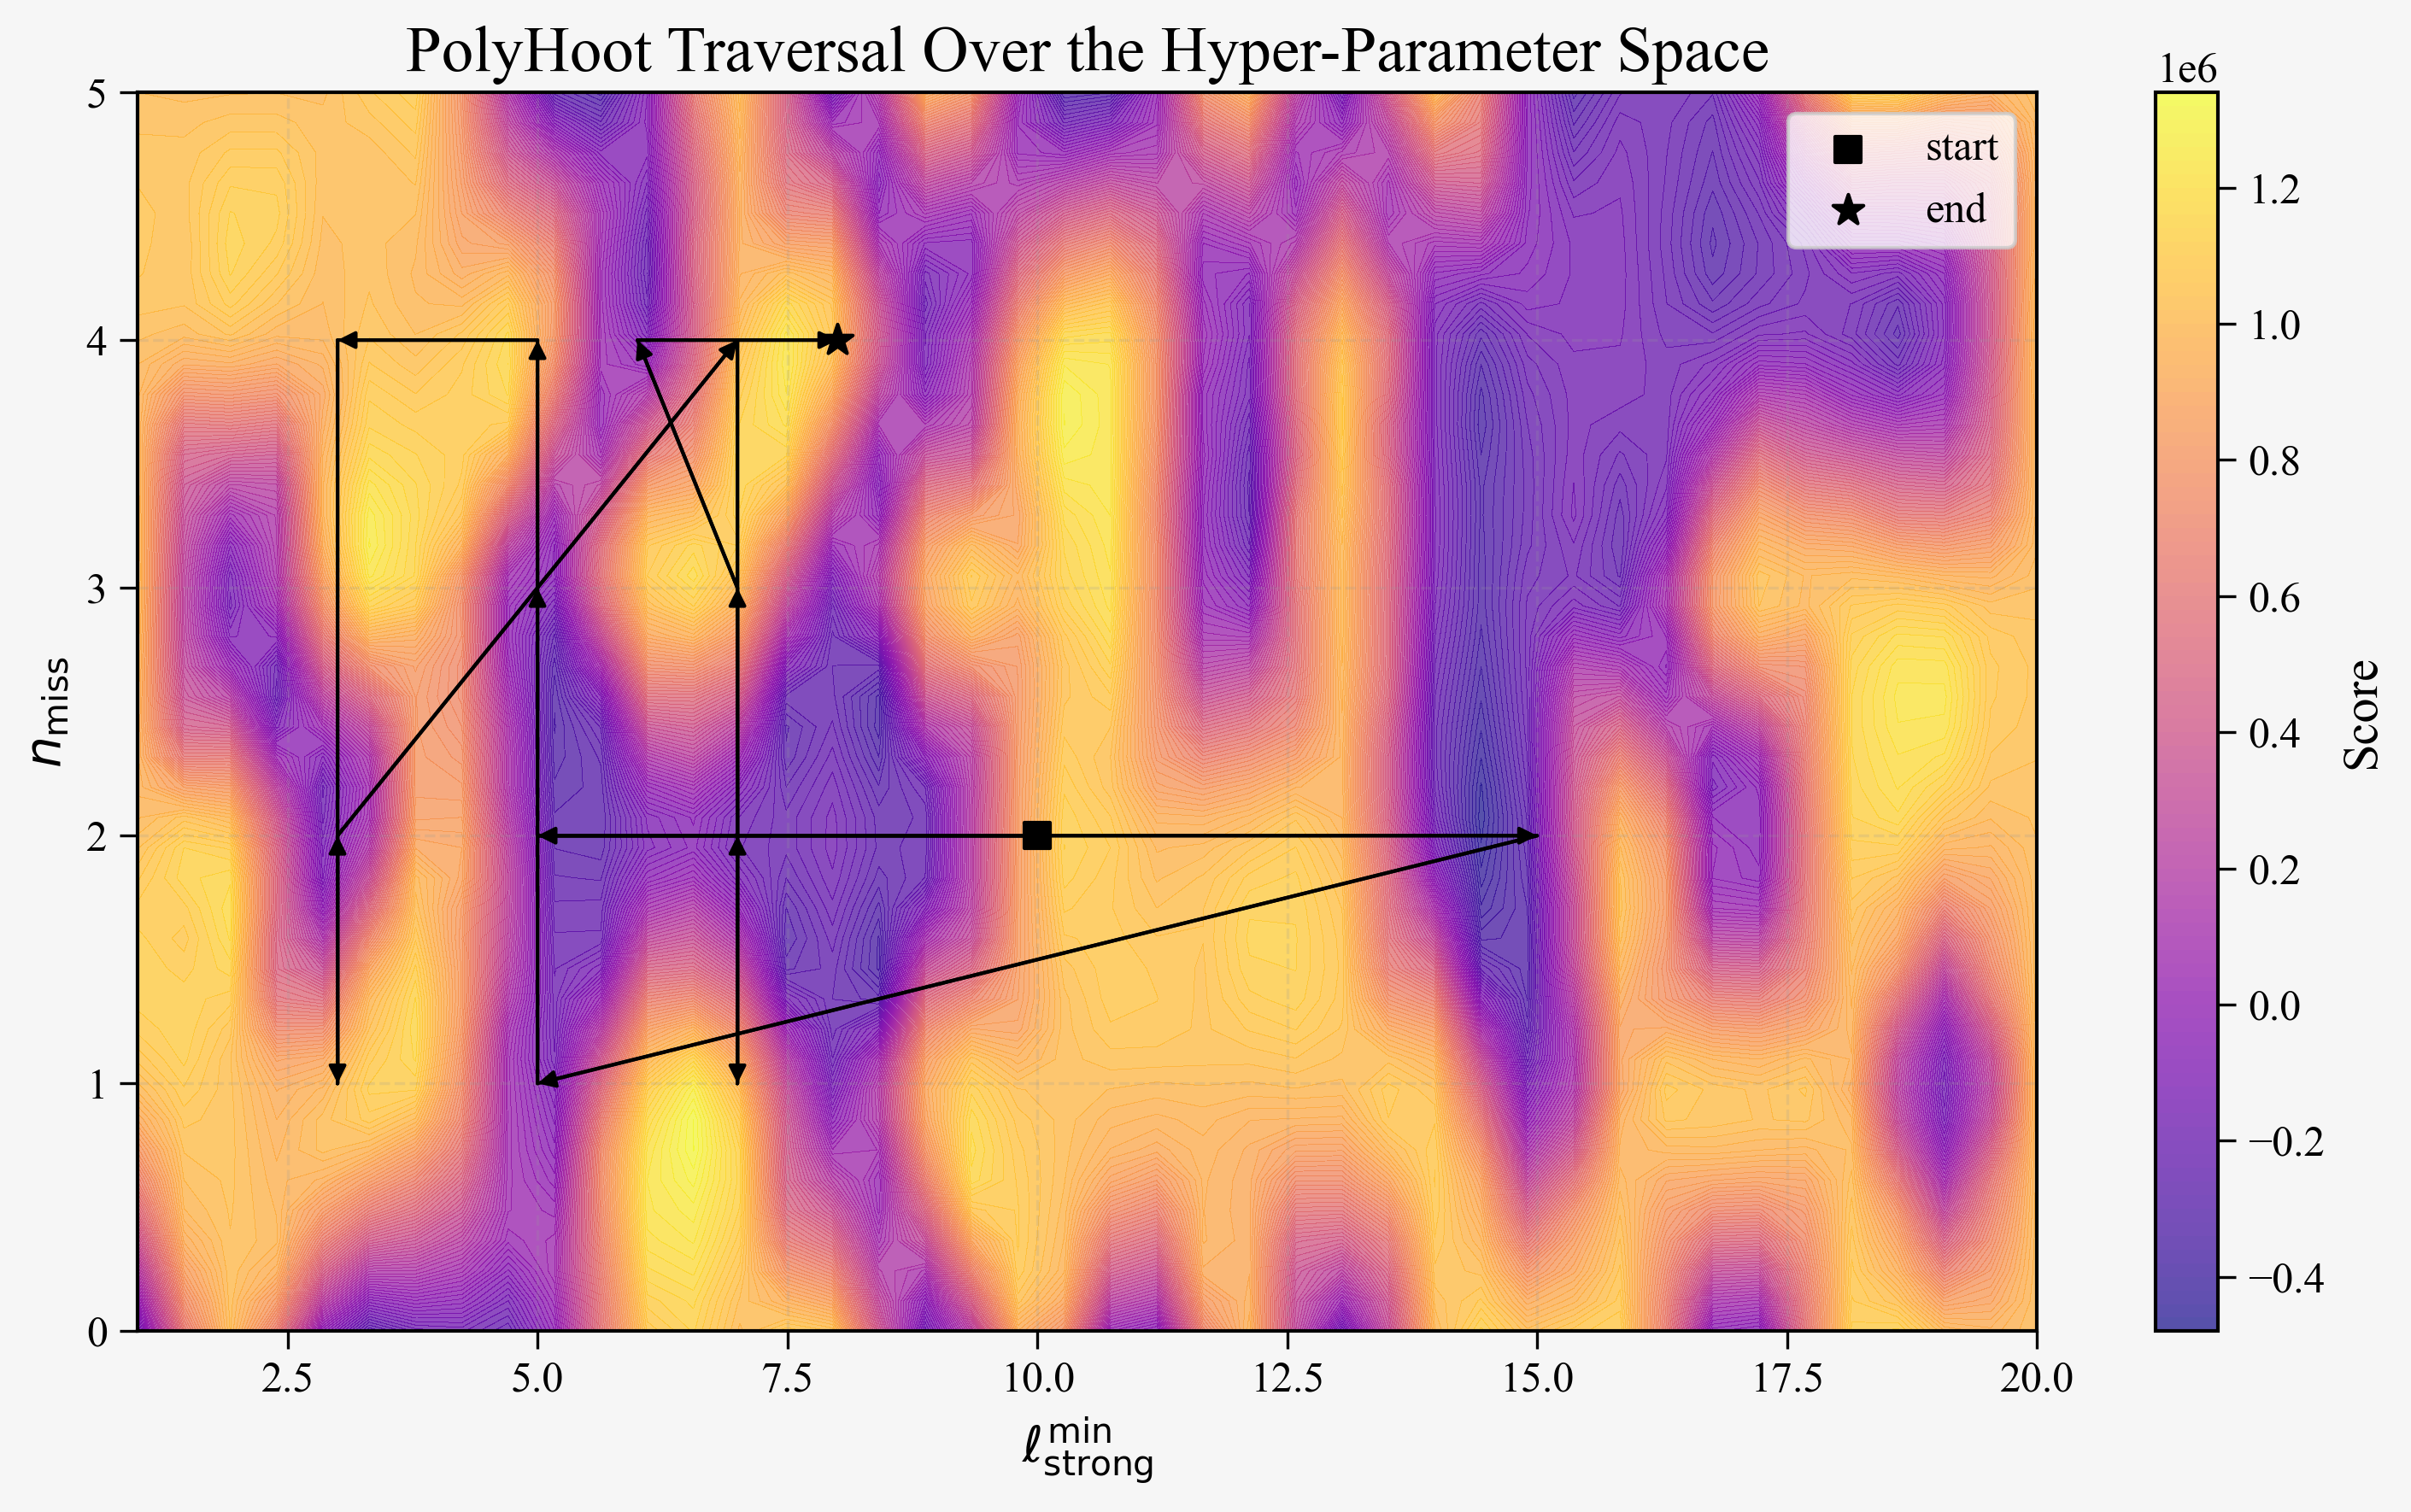

In [ ]:
plot_score_landscape(
    df,
    x_param='min_strong_track_length',
    y_param='allowed_missed_modules',
    path=DF_polyhoot,            
    figsize=(10, 6),
    cmap='plasma',
    alpha=0.7,
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    cbar_label='Score',
    dpi=300,
    title="PolyHoot Traversal Over the Hyper-Parameter Space",
    XTitle=r"$\ell_{\mathrm{strong}}^{\min}$",
    YTitle=r"$n_{\mathrm{miss}}$",
    resolution=configuration["optimizer"]["resolution"],
    show_scatter=False,
    path_color="k",          # NEW: color for the path/arrows
    path_linewidth=1,        # NEW: thickness of the connecting lines
    arrow_size=10,            # NEW: size of the arrow heads
    arrow_style="-|>"
)

# Lets see GirdSearch Scatter vs. PolyHoot

In [ ]:
def plot_expected_score_by_param(
    df,
    df2,
    params=None,
    figsize=(8, 5),
    colors=None,
    linestyles=None,
    linewidths=None,
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    legend_fontsize=12,
    dpi=300,
    Title="INSERT",
    XAxis="INSERT"
):
    """
    Plot expected score (mean score) versus each hyperparameter in `params` with publication-quality styling.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing 'score' and hyperparameter columns.
    params : list[str], optional
        List of hyperparameter column names to plot. 
        If None, will use all columns except 'id' and 'score'.
    figsize : tuple, default=(8, 5)
        Figure size in inches.
    colors : list[str], optional
        Line colors for each parameter. Defaults to Tableau 10.
    linestyles : list[str], optional
        Line styles for each parameter. Defaults to solid lines.
    linewidths : list[float], optional
        Line widths for each parameter. Defaults to 1.5.
    title_fontsize, label_fontsize, tick_fontsize, legend_fontsize, dpi : int
        Matplotlib styling parameters.
    """
    if params is None:
        params = [c for c in df.columns if c not in ['id', 'score']]
    n = len(params)
    # Default style arrays
    if colors is None:
        gray_cmap = cm.get_cmap('Greys')
        gray_levels = np.linspace(0.3, 0.7, n)            # adjust range for contrast
        colors = [gray_cmap(g) for g in gray_levels]
        print(colors)
    if linestyles is None:
        linestyles = ['-'] * n
    if linewidths is None:
        linewidths = [1.5] * n

    # 1) Configure rcParams for publication‐quality styling
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "legend.fontsize":   legend_fontsize,
        "figure.dpi":        dpi,
        "axes.linewidth":    1.0,
        "xtick.major.size":  5,
        "ytick.major.size":  5,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    means = df.groupby(params)['score'].mean()
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(
        means.index, 
        means.values,
        label=f'Expected Score',
        color=colors[0],
        linestyle=linestyles[0],
        linewidth=linewidths[0]
    )
    ax.set_title(Title, pad=10)
    ax.set_xlabel(XAxis, fontsize=label_fontsize)
    ax.set_ylabel('Expected Score', fontsize=label_fontsize)
    # If many unique values, rotate xticks
    if len(means.index) > 10:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


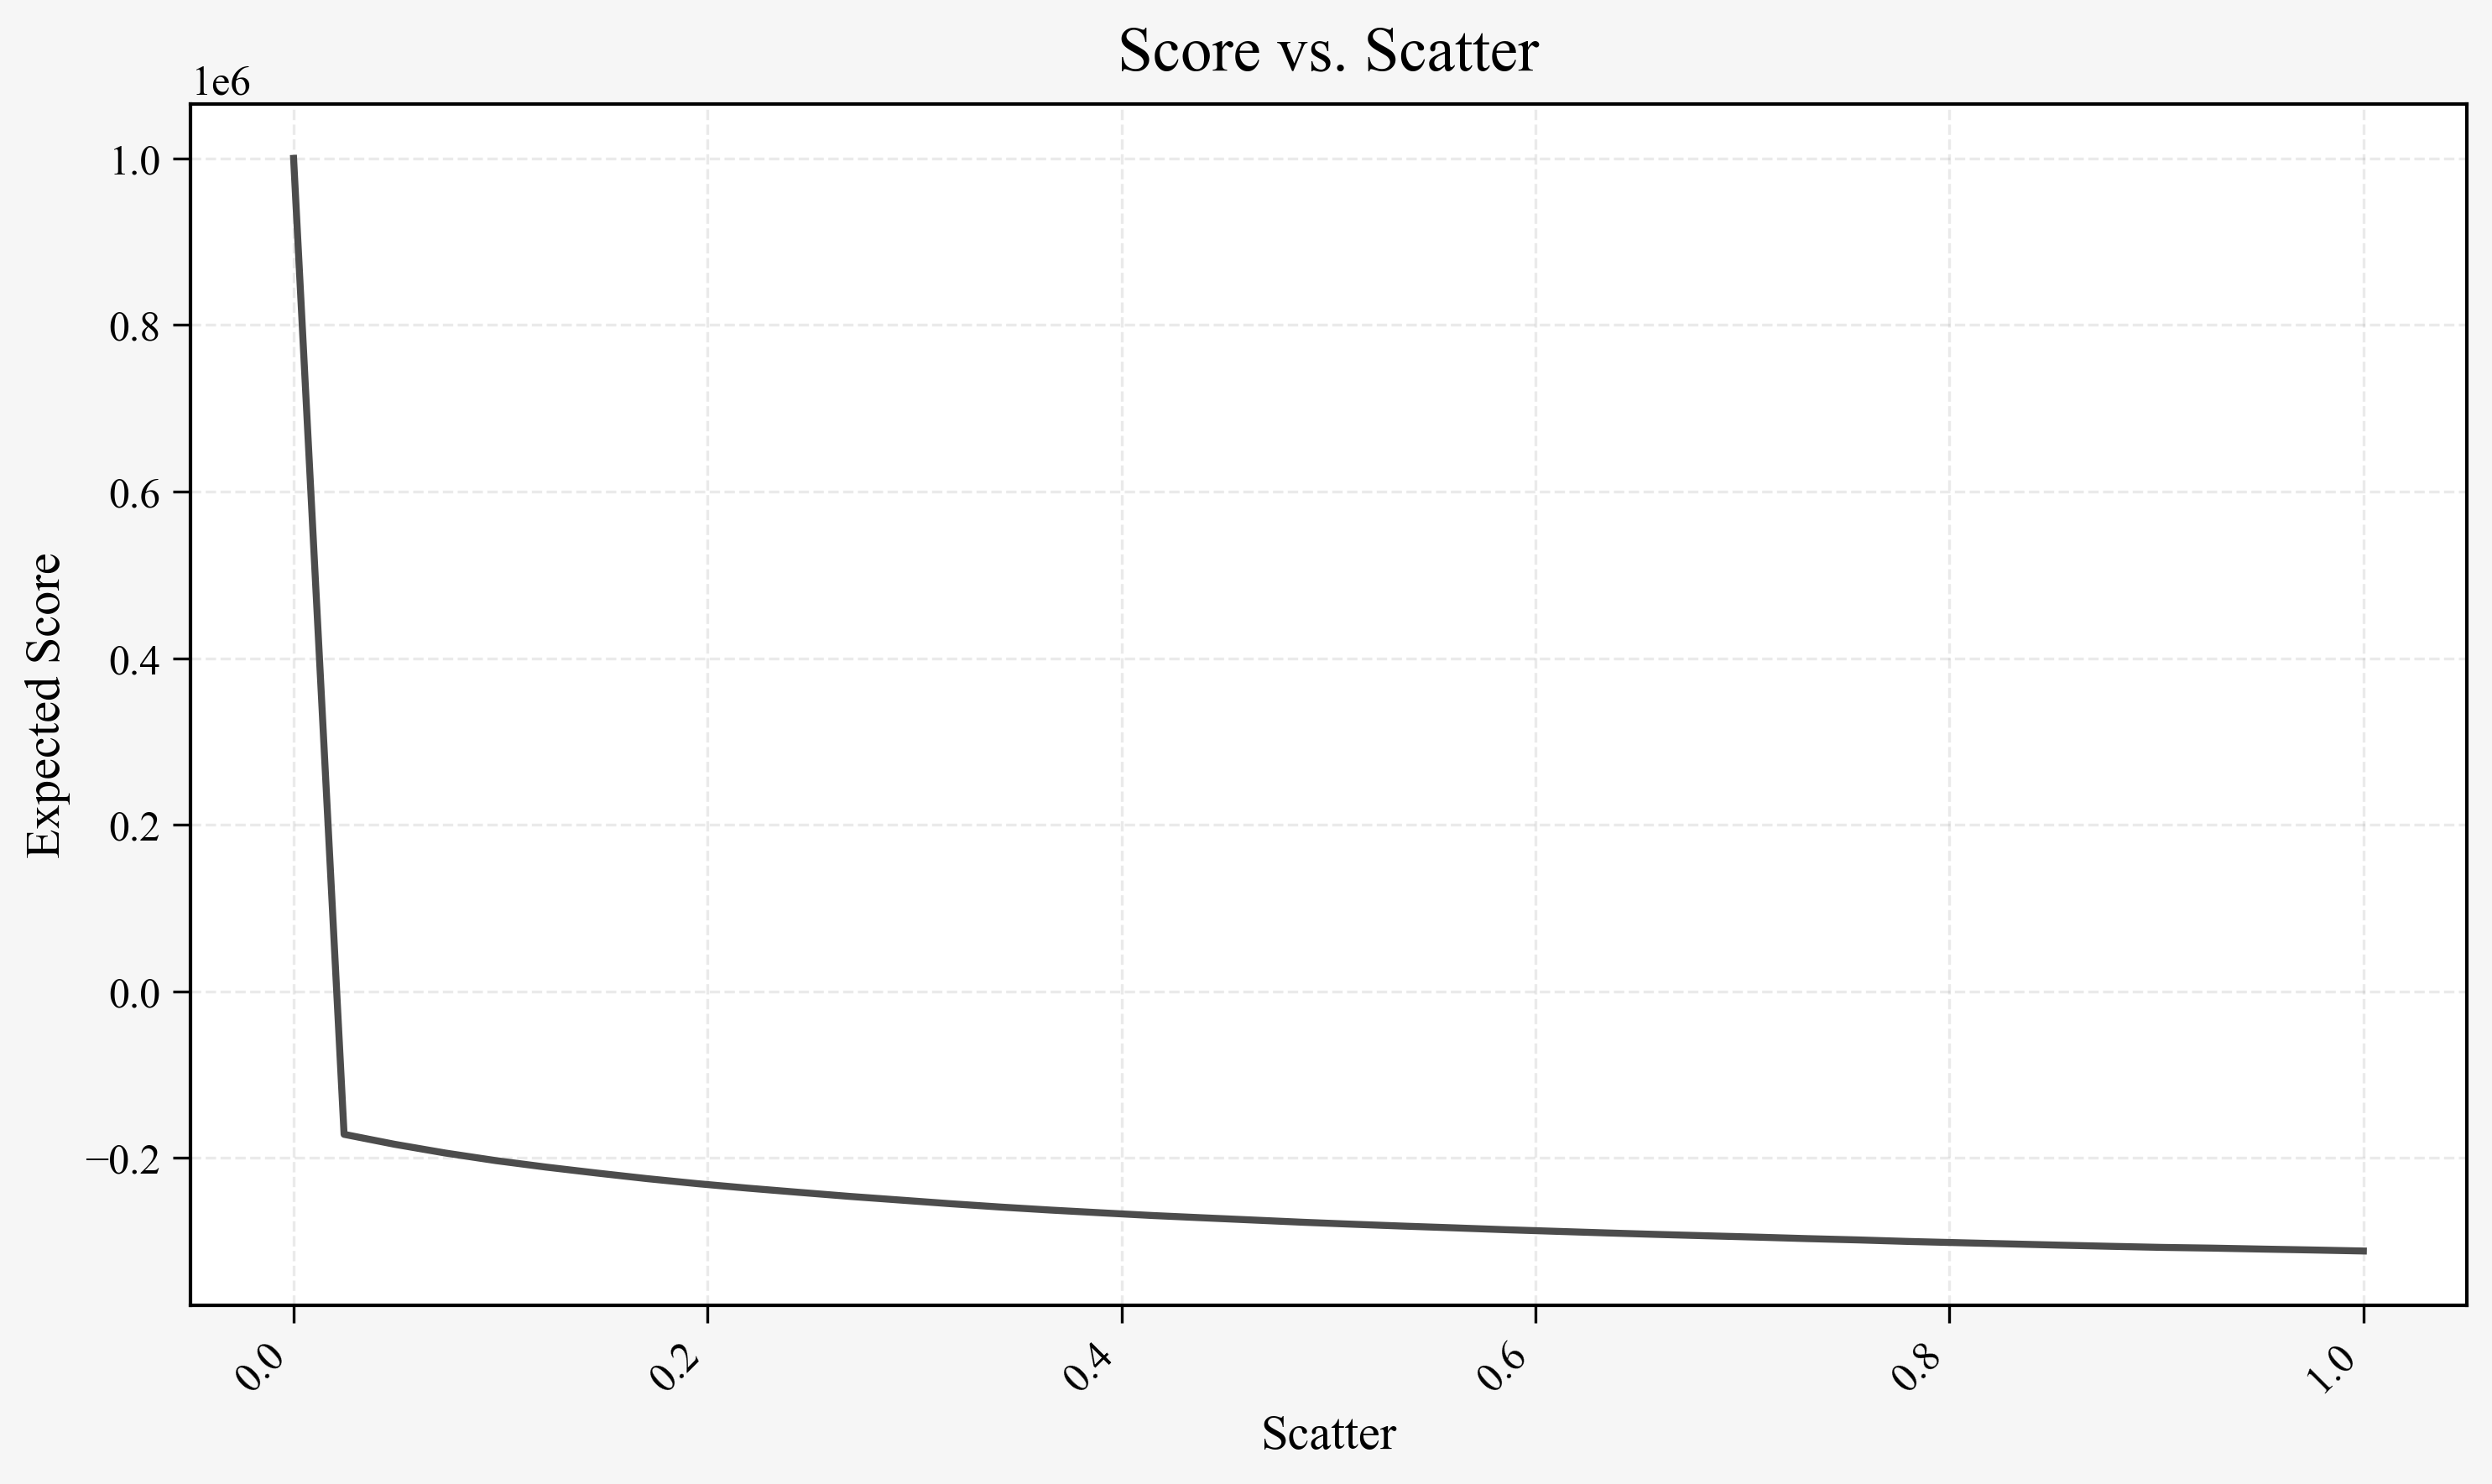

In [ ]:
plot_expected_score_by_param(
    df,
    DF_polyhoot,
    params='scatter',
    figsize=(10,6),
    colors=['#4C4C4C'],
    linestyles=['-','--'],
    linewidths=[2,2],
    Title="Score vs. Scatter",
    XAxis="Scatter"
)

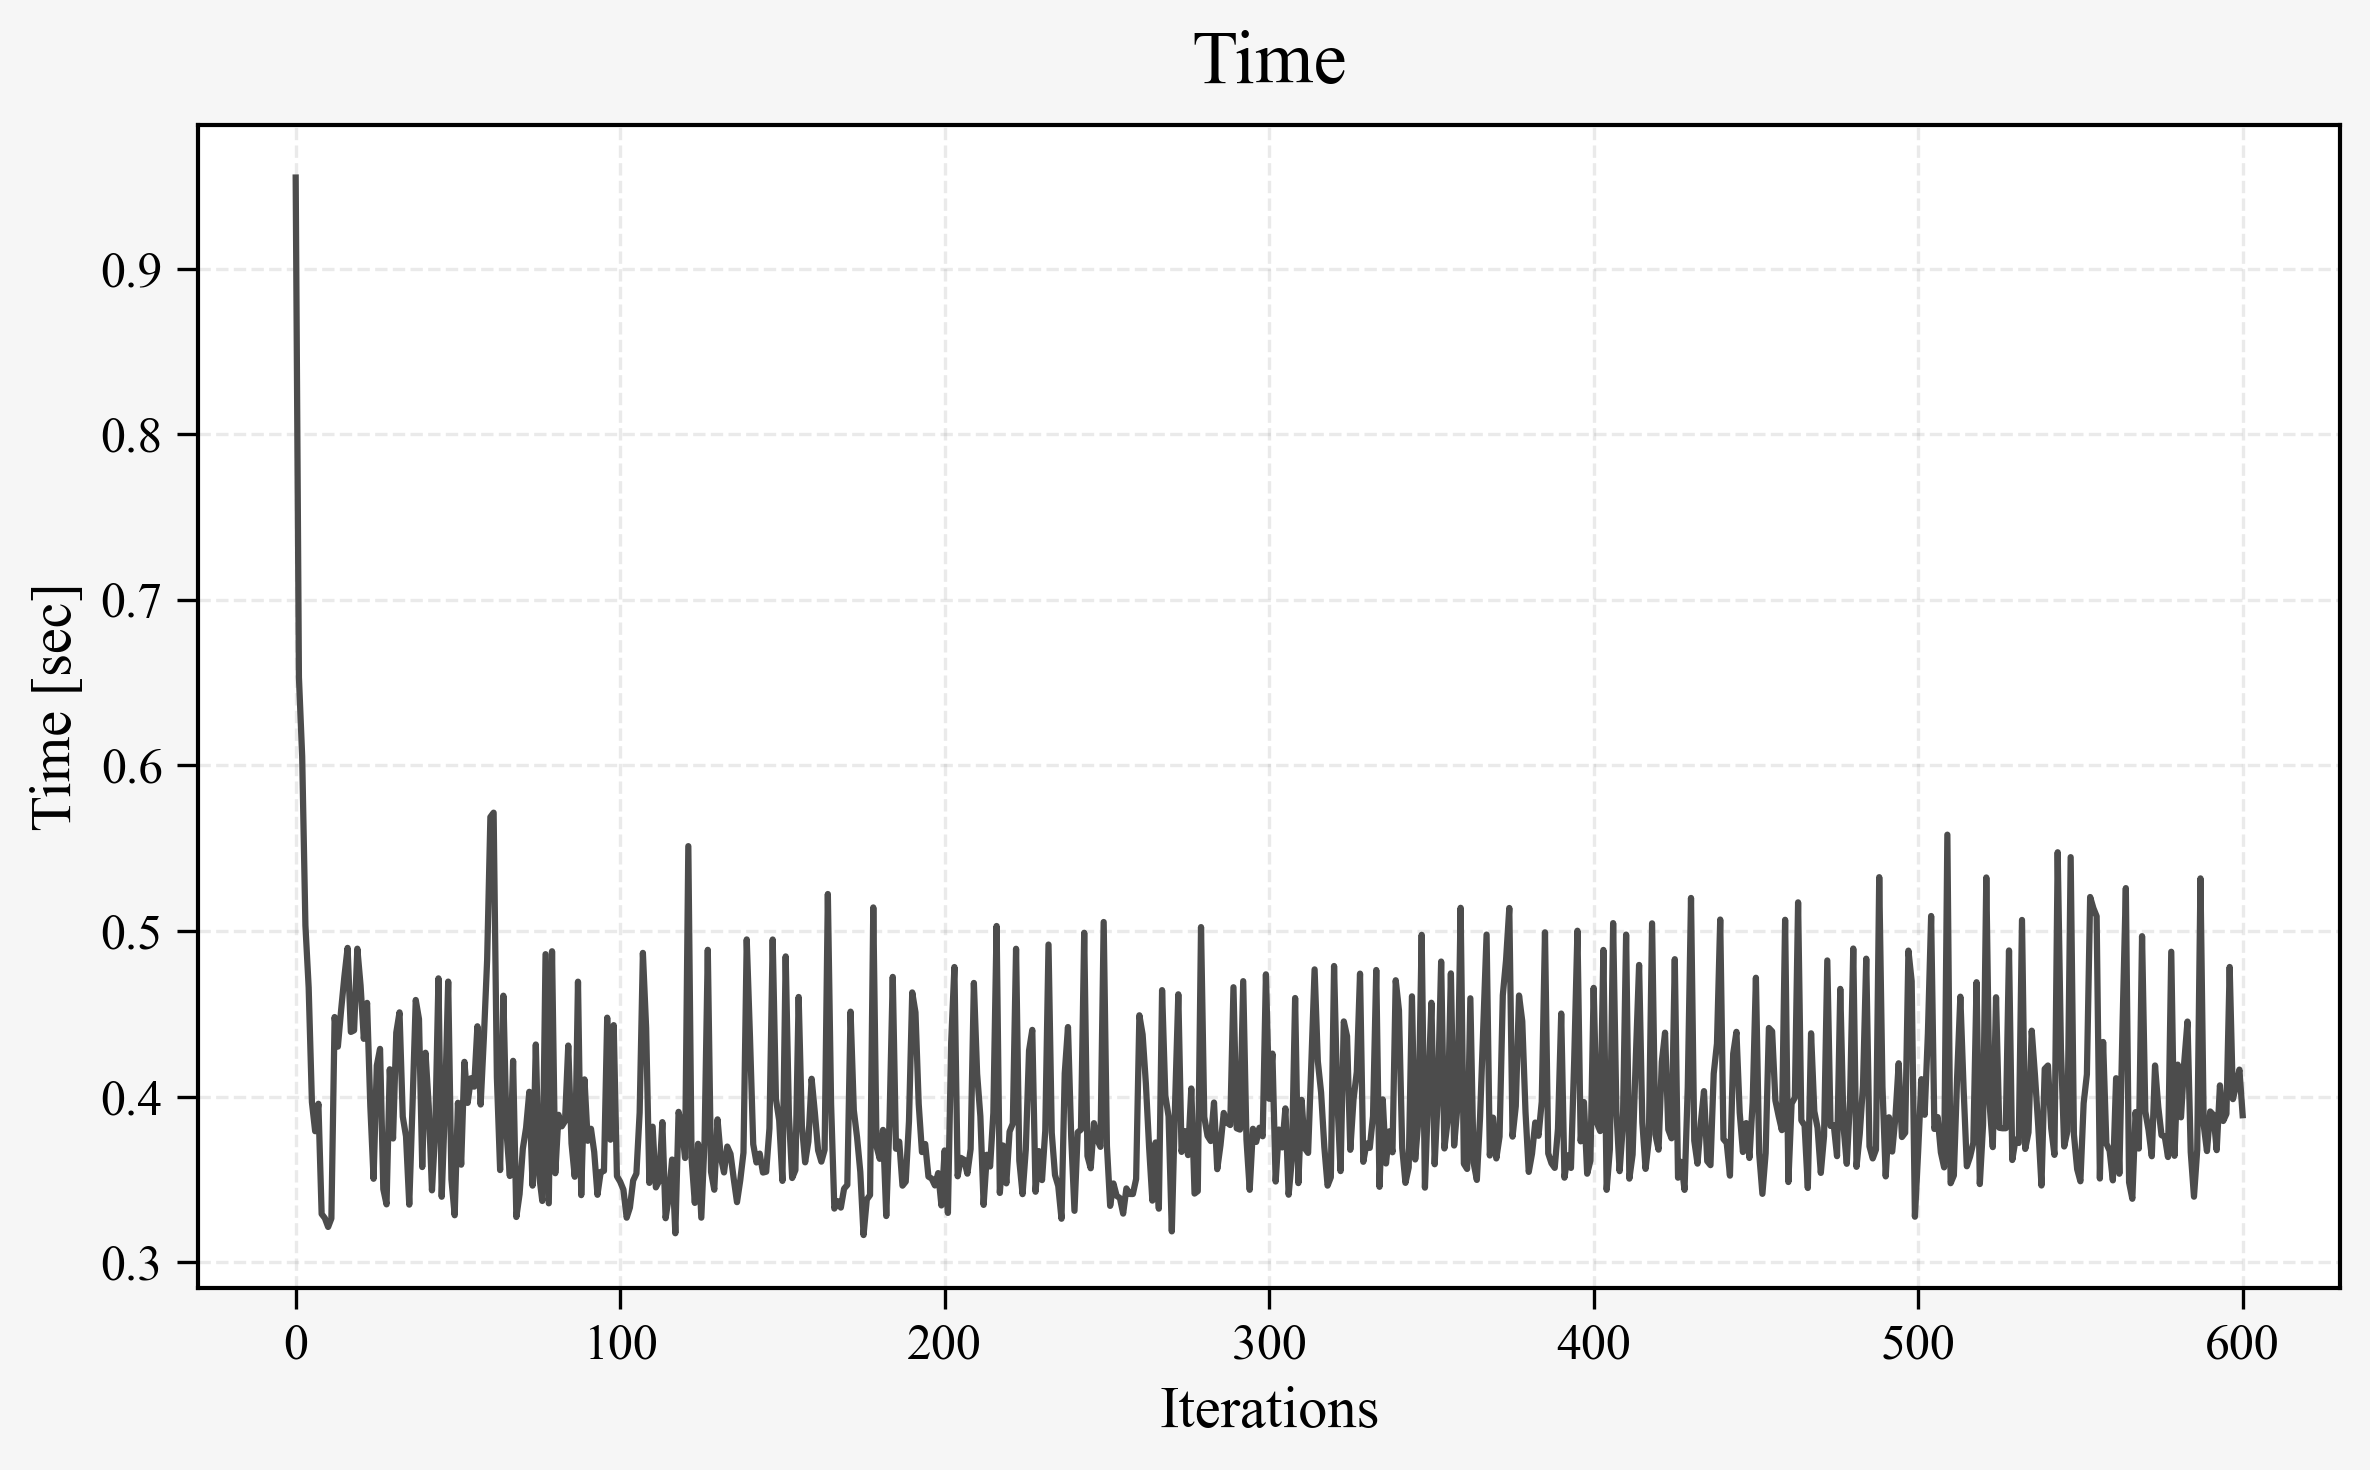

In [ ]:
df2 = parse_results(path + "result_GridSearch_TF_1_extensive.jsonl")
plot_convergence_time(df2)

In [ ]:
get_config("result_GridSearch_TF_1_extensive.jsonl")

{'solverName': 'GridSearch',
 'num_events': 100,
 'intra_node': True,
 'max_runs': 1000000,
 'optimizer': {'objective': 'min',
  'nested': True,
  'weights': [0.4, 0.2, 0.3, -5.0],
  'resolution': 10},
 'reconstruction_algo': 'ST'}